# Proyecto: Análisis de mercado inmobiliario

El objetivo es aplicar las técnicas incorporadas (Transformación de Datos, Optimización de Hiperparámetros, Modelos Avanzados, etc.) para generar un modelo que tenga un mejor desempeño que el modelo generado en el proyecto anterior. Luego, interpreta ese modelo para responder la siguiente pregunta: ¿qué podemos aprender de nuestro problema estudiando el modelo que generamos?

El trabajo se organiza en tres partes:

## PARTE A - Transformación de Datos

Elige cuáles de las siguientes tareas son apropiadas para su dataset. Justifica e implementa:

    1.Detección y eliminación de Outliers

    2.Encoding

    3.Imputación de valores faltantes

    4.Escalado de datos

    5.Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA).

Vuelve a entrenar el modelo implementado en la Entrega 01 - en particular, el árbol de decisión - y evalúa su desempeño a partir del dataset obtenido luego de transformar los datos. ¿Hay una mejora en su desempeño? Sea cual sea la respuesta, intenta explicar a qué se debe.

## PARTE B - Modelos Avanzados

Elige dos de los modelos avanzados vistos (en el caso de regresión, considera una regresión lineal con atributos polinómicos y regularización). Entrénalos y evalúalos con sus argumentos por defecto. No te olvides de hacer un train/test split y usar Validación Cruzada.

Optimiza sus hiperparámetros mediante Validación Cruzada y Grid Search o Random Search.

Compara el desempeño de los nuevos modelos entre sí y con el modelo de la Parte A. ¿Cuál elegirías? Justifica.

## PARTE C - Interpretación de modelos

De acuerdo a lo que el modelo permite, responde algunas o todas las siguientes preguntas:

¿Qué variables fueron relevantes para el modelo para hacer una predicción? ¿Cuáles no? Si usaste una regresión lineal con regularización, presta atención a los parámetros (pendientes) obtenidas. Si usaste un modelo de ensamble en árboles, además de ver la importancia de cada atributo, también elige algunos árboles al azar y observa qué atributos considera importantes. ¿En qué se diferencian esos árboles? ¿Por qué? Finalmente, responde, ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?

¿Cómo es la distribución de errores (regresión) o qué clases se confunden entre sí (clasificación)? ¿Dónde falla? ¿A qué se debe?

 **DESAFÍO OPCIONAL**

Aplica una técnica de Clustering sobre el dataset. Puedes combinar con técnicas de reducción de dimensionalidad para facilitar la visualización. ¿Qué clusters encuentras? ¿A qué pueden corresponder? Te dejamos preguntas que pueden servir como disparadoras: ¿qué barrios se parecen más entre sí?¿qué tipos de propiedades se parecen más entre sí?

In [1]:
from pandas_profiling import ProfileReport
# Importamos las librerías generales
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Librerías para el Preprocesamiento 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.preprocessing import PolynomialFeatures


# librerías necesarias para el ML
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

# Librerías para mediciones de Error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Libreías para Optimización de Hiperparámetros
from sklearn.model_selection import RandomizedSearchCV

# Librerías para Clusterización 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

sns.set(style="white", context="talk")
# Definición de Tipo, tamaño, color y ancho de las Fuentes para los títulos de los gráficos
title_font= {"family" : "Cambria",
             "size" : 16,
             "color" : "black",
             "weight" : "roman"}

In [2]:
def evaluo_regresion(model,x,y, X_train, X_test, y_train, y_test):

    # Predigo y evaluo sobre el set de entrenamiento
    y_train_pred = model.predict(X_train)
    # Calculo el error en el set de entrenamiento
    r2_train = r2_score(y_train, y_train_pred)
    print(f'Error R2 en Train: {r2_train}')
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')

    # Predigo y evaluo sobre el set de evaluación
    y_test_pred = model.predict(X_test)
    # Calculo el error en el set de evaluación
    r2_test =  r2_score(y_test, y_test_pred)
    print(f'Error R2 en Test: {r2_test}')
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}') 
    
    #Grafico los resultados

    plt.figure(figsize = (10,6))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 30, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 30, label = 'test')
    plt.xlabel('errores')
    plt.grid(axis='x')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
        ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y_test')
    plt.ylabel('y_test_pred')
    plt.tight_layout()
    plt.grid(axis='x')
    plt.show();

In [3]:
def elimino_outliers(dataset,var):
    '''
    Dado un dataset y un feature 
    devuelve la mascara(filtro) 
    con los datos a eliminar en 
    ese feature del dataset.   
    '''
    
    q25,q75 = np.percentile(dataset[var], [25,75])
    iqr = q75 - q25
    minimo = q25 - 1.5*iqr
    maximo = q75 + 1.5*iqr
    mascara_outliers = np.logical_or(dataset[var] < minimo, dataset[var] > maximo)
    return mascara_outliers

## PARTE A - Transformación de Datos

In [4]:
# Cargo el dataset
data=pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')

#profile = pandas_profiling.ProfileReport(data)
#profile.to_file('dataEda.htlm')

In [5]:
# Lista la información
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146660 entries, 0 to 146659
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   start_date       146660 non-null  object 
 1   end_date         146660 non-null  object 
 2   created_on       146660 non-null  object 
 3   lat              136735 non-null  float64
 4   lon              136701 non-null  float64
 5   l1               146660 non-null  object 
 6   l2               146660 non-null  object 
 7   l3               146660 non-null  object 
 8   rooms            146660 non-null  float64
 9   bedrooms         146660 non-null  float64
 10  bathrooms        140703 non-null  float64
 11  surface_total    126133 non-null  float64
 12  surface_covered  125046 non-null  float64
 13  price            146660 non-null  float64
 14  currency         146660 non-null  object 
 15  title            146660 non-null  object 
 16  description      146660 non-null  obje

In [6]:
#Listo su forma
data.shape

(146660, 19)

Como en el Proyecto_01 no tendré en cuenta para mi análisis las columnas `start_date, end_date , created_on, lat, lon, currency, title, description y operation_type` ya que no solo algunas cuentan con valores faltantes sino que considero que no me ayudarán a predecir mi variable objetivo que es `price`.

In [7]:
data1 = data[['l2','l3','rooms','bedrooms','bathrooms','surface_total','surface_covered','property_type','price']]

In [8]:
data1.head()

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type,price
0,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,Departamento,153000.0
1,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,PH,159000.0
2,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,PH,125000.0
3,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,PH,295000.0
4,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,PH,40000.0


In [9]:
data1.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,146660.000000,146660.000000,140703.000000,126133.000000,125046.000000,1.466600e+05
mean,3.079817,1.983240,1.599994,216.872888,112.818011,2.412211e+05
std,1.416352,1.151304,0.889324,2037.606649,916.857584,3.185195e+05
min,1.000000,0.000000,1.000000,10.000000,1.000000,5.500000e+03
25%,2.000000,1.000000,1.000000,52.000000,47.000000,1.110000e+05
50%,3.000000,2.000000,1.000000,78.000000,68.000000,1.660000e+05
75%,4.000000,3.000000,2.000000,140.000000,108.000000,2.650000e+05
max,35.000000,15.000000,14.000000,193549.000000,126062.000000,3.243423e+07


**1. Imputación de valores faltantes**
   Mi primer paso será guardar una copia de mi dataset para luego analizar y comparar las diferenres estrategias aplicadas   y elegir aquella que no me modique la esencia de mi dataset. Primero, aplico los siguientes pasos:
   * Identifico los valores faltantes en mi dataset. Existen dos estratégias: 
   * Estrategia 1. Elimino las filas que contienen valores faltantes. Mediante la función **dropna()** de Pandas.
   * Estrategia 2. Imputo  la mediana a través del uso de la clase de Scikit-Learn **SimpleImputer**.
   

In [10]:
data2 = data1.copy()

In [11]:
data2.isnull().sum()

l2                     0
l3                     0
rooms                  0
bedrooms               0
bathrooms           5957
surface_total      20527
surface_covered    21614
property_type          0
price                  0
dtype: int64

* Debido a que tanto la superfice total como la cubierta y los baños tienen en total un 30% de valores fatantes con respecto a todo el dataset optaré por aplicar la estrategia 2 `Simple Imputer` con la elección de la **median** para rellenar los valores faltantes NaN. Elijo la `mediana` ya que teniendo en cuenta el análisis de los datos obtenidos en el Proyecto_01 donde pude inferir que en general la distribución del dataset presenta una asimetría positiva (o a la derecha) por lo tanto la media no sería el valor representativo para reemplazar a los valores faltantes.

* La primero que hago es crear un nuevo dataset que contiene las columnas (bathrooms, surface_total y surface_covered) a las que le imputaré los valores faltantes. Luego eliminaré de mi dataset original esas columnas y lo reemplazaré con las nuevas colunmas resultantes de la aplicación del SimpleImputer.

In [12]:
imputer= SimpleImputer(missing_values=np.nan, strategy='median')
data3= pd.DataFrame(imputer.fit_transform(data2[['bathrooms','surface_total','surface_covered']]),columns=data2[['bathrooms','surface_total','surface_covered']].columns)

In [13]:
data3.isnull().sum()

bathrooms          0
surface_total      0
surface_covered    0
dtype: int64

In [14]:
data2.drop(['bathrooms','surface_total','surface_covered'], axis = 'columns', inplace=True)
data2

,l2,l3,rooms,bedrooms,property_type,price
0,Capital Federal,San Cristobal,7.0,7.0,Departamento,153000.0
1,Capital Federal,Boedo,2.0,1.0,PH,159000.0
2,Capital Federal,Palermo,2.0,1.0,PH,125000.0
3,Capital Federal,Palermo,2.0,1.0,PH,295000.0
4,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,PH,40000.0
...,...,...,...,...,...,...
146655,Bs.As. G.B.A. Zona Sur,Berazategui,2.0,1.0,Departamento,165000.0
146656,Bs.As. G.B.A. Zona Norte,Pilar,4.0,3.0,Departamento,130000.0
146657,Bs.As. G.B.A. Zona Norte,Pilar,1.0,1.0,Departamento,73000.0
146658,Bs.As. G.B.A. Zona Norte,Pilar,2.0,1.0,Departamento,68000.0


In [15]:
data4=pd.concat([data2, data3], axis=1, sort=False)

In [16]:
data4.head()

,l2,l3,rooms,bedrooms,property_type,price,bathrooms,surface_total,surface_covered
0,Capital Federal,San Cristobal,7.0,7.0,Departamento,153000.0,2.0,140.0,140.0
1,Capital Federal,Boedo,2.0,1.0,PH,159000.0,2.0,70.0,58.0
2,Capital Federal,Palermo,2.0,1.0,PH,125000.0,1.0,45.0,45.0
3,Capital Federal,Palermo,2.0,1.0,PH,295000.0,1.0,85.0,50.0
4,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,PH,40000.0,1.0,50.0,35.0


  **2. Encoding**
  
   Sobre las variables string (property_type, l2 y l3) aplicaré diferentes métodos de encoding. A saber:
   * Función map de Pandas para `property_type y l3`
   * OneHotEncoding para los barrios  `l2`

In [17]:
data4.property_type.value_counts()

Departamento       107326
Casa                21521
PH                  14298
Lote                 1312
Oficina               658
Otro                  374
Local comercial       325
Casa de campo         322
Depósito              265
Cochera               259
Name: property_type, dtype: int64

* Realizare mediante la función `map` la codificación por tipo propiedad. Transformaré unicamente las propiedades tipo Departamente(0), PH(1) y Casas(2) ya que posee la mayor frecuencia y al resto de propiedades las agruparé todas dentro del código 3 como otras tipos de propiedades.

In [18]:
property_dic={'Departamento':0, 
              'PH':1, 'Casa':2,'Lote':3, 
              'Oficina':3, 'Cochera':3, 'Local comercial':3, 
              'Otro':3, 'Depósito':3, 'Casa de campo':3}

In [19]:
data4.loc[:,'property_type_n'] = data4.loc[:,'property_type'].map(property_dic)
data4.head()

,l2,l3,rooms,bedrooms,property_type,price,bathrooms,surface_total,surface_covered,property_type_n
0,Capital Federal,San Cristobal,7.0,7.0,Departamento,153000.0,2.0,140.0,140.0,0
1,Capital Federal,Boedo,2.0,1.0,PH,159000.0,2.0,70.0,58.0,1
2,Capital Federal,Palermo,2.0,1.0,PH,125000.0,1.0,45.0,45.0,1
3,Capital Federal,Palermo,2.0,1.0,PH,295000.0,1.0,85.0,50.0,1
4,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,PH,40000.0,1.0,50.0,35.0,1


In [20]:
data4.property_type_n.value_counts()

0    107326
2     21521
1     14298
3      3515
Name: property_type_n, dtype: int64

In [21]:
data4['l2'].value_counts()

Capital Federal             92539
Bs.As. G.B.A. Zona Norte    24282
Bs.As. G.B.A. Zona Sur      17173
Bs.As. G.B.A. Zona Oeste    12666
Name: l2, dtype: int64

In [22]:
zonas_dic = {'Capital Federal': 0, 'Bs.As. G.B.A. Zona Norte':1,
             'Bs.As. G.B.A. Zona Sur':2,'Bs.As. G.B.A. Zona Oeste':3}

In [23]:
data4.loc[:,'l2_n']= data4.loc[:,'l2'].map(zonas_dic)
data4.tail()

,l2,l3,rooms,bedrooms,property_type,price,bathrooms,surface_total,surface_covered,property_type_n,l2_n
146655,Bs.As. G.B.A. Zona Sur,Berazategui,2.0,1.0,Departamento,165000.0,1.0,54.0,48.0,0,2
146656,Bs.As. G.B.A. Zona Norte,Pilar,4.0,3.0,Departamento,130000.0,2.0,164.0,90.0,0,1
146657,Bs.As. G.B.A. Zona Norte,Pilar,1.0,1.0,Departamento,73000.0,1.0,50.0,35.0,0,1
146658,Bs.As. G.B.A. Zona Norte,Pilar,2.0,1.0,Departamento,68000.0,1.0,38.0,38.0,0,1
146659,Bs.As. G.B.A. Zona Norte,Pilar,3.0,2.0,Departamento,98000.0,1.0,75.0,75.0,0,1


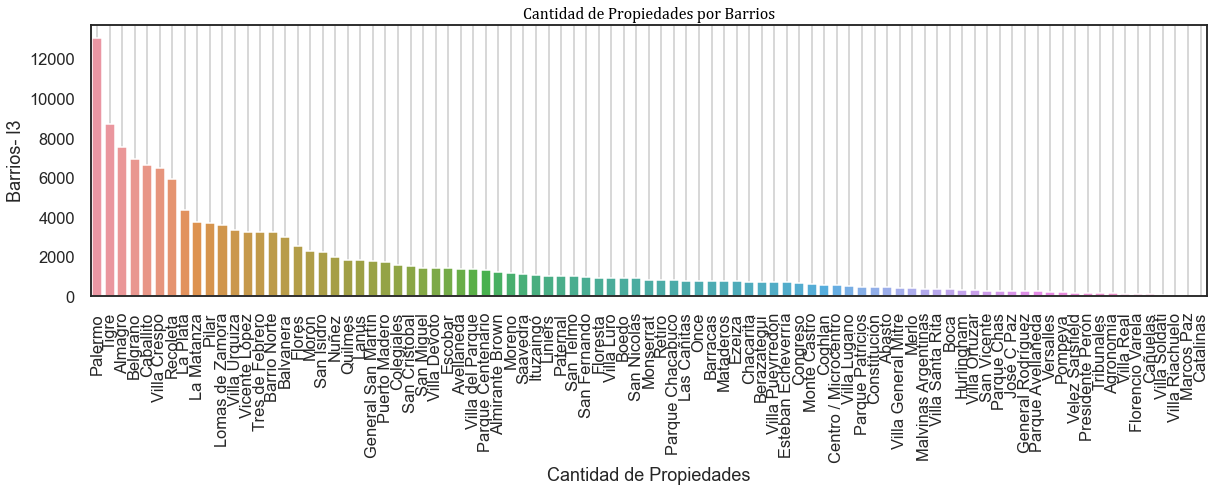

In [24]:
# Estudio la distribución de los barrios

fig, ax = plt.subplots(figsize=(20,5))
ax = sns.countplot(data = data4, x = "l3" ,order=data4['l3'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.ylabel('Barrios- l3')
plt.xlabel('Cantidad de Propiedades')
plt.title('Cantidad de Propiedades por Barrios', fontdict = title_font)
plt.grid(False) 
plt.grid(axis='x')
plt.show();

In [25]:
data4.l3.value_counts().sort_values(ascending=False).head(11)

Palermo            13073
Tigre               8718
Almagro             7527
Belgrano            6935
Caballito           6650
Villa Crespo        6494
Recoleta            5917
La Plata            4354
La Matanza          3757
Pilar               3709
Lomas de Zamora     3599
Name: l3, dtype: int64

In [26]:
# Analice la media de los precios por barrios
data4.groupby('l3').agg({'price':['mean']}).reset_index()

,l3,price
,,mean
0,Abasto,171669.225108
1,Agronomía,195261.387879
2,Almagro,180403.760861
3,Almirante Brown,243656.008958
4,Avellaneda,127272.403650
...,...,...
84,Villa Riachuelo,535988.071429
85,Villa Santa Rita,162580.677966
86,Villa Soldati,122472.463768


* Como resultado de mi análisis observó que la concentración de las propiedades está dada en un grupo de barrios (aproximadamente 11) y en el resto de los barrios dicha concentración empieza a decrecer pero es sustancialmente menor al primer grupo, a continuación detallo las acciones que realizaré sobre feature `l3`:
    1. Primero creo un array con los barrios más significativos para codificarlos y el resto de los barrios los ubicaré en la categoría Otros. 
    2. Luego a partir de esa codificación aplicaré el `OneHotEncode` para convertir las features categóricas en numéricas. Justifico la elección del `OneHoteEncode` sobre el `LabelEncode` para evitar una jerarquización de los barrios ya que para mi entender no sería correcto.

In [27]:
barrios_imp =['Palermo','Tigre','Almagro','Villa Crespo','Caballito','Belgrano','Recoleta','La Plata','La Matanza','Pilar']
data5 = data4.copy()
data5.loc[~data5['l3'].isin(barrios_imp), 'l3'] = 'Otros'
data5.head()

,l2,l3,rooms,bedrooms,property_type,price,bathrooms,surface_total,surface_covered,property_type_n,l2_n
0,Capital Federal,Otros,7.0,7.0,Departamento,153000.0,2.0,140.0,140.0,0,0
1,Capital Federal,Otros,2.0,1.0,PH,159000.0,2.0,70.0,58.0,1,0
2,Capital Federal,Palermo,2.0,1.0,PH,125000.0,1.0,45.0,45.0,1,0
3,Capital Federal,Palermo,2.0,1.0,PH,295000.0,1.0,85.0,50.0,1,0
4,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,PH,40000.0,1.0,50.0,35.0,1,2


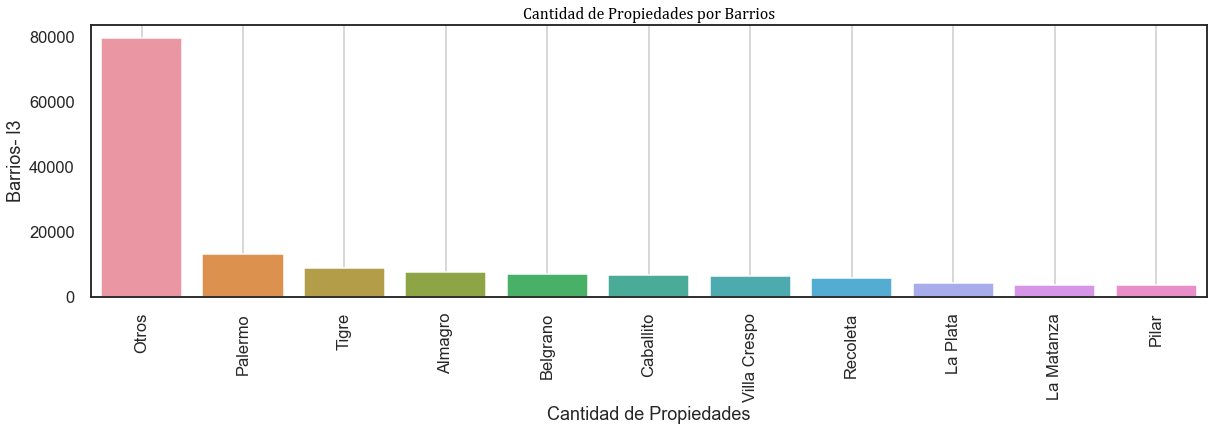

In [28]:
# Estudio la distribución de los barrios

fig, ax = plt.subplots(figsize=(20,5))
ax = sns.countplot(data = data5, x = "l3" ,order=data5['l3'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.ylabel('Barrios- l3')
plt.xlabel('Cantidad de Propiedades')
plt.title('Cantidad de Propiedades por Barrios', fontdict = title_font)
plt.grid(False) 
plt.grid(axis='x')
plt.show();

In [29]:
ohc = OneHotEncoder()
ohe = ohc.fit_transform(data5.l3.values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(ohe, columns= ['B.'+str(ohc.categories_[0][i])
                                            for i in range(len(ohc.categories_[0]))])
# Uno el nuevo dataframe con el original 
data6 = pd.concat([data5, dfOneHot], axis= 1)

In [30]:
data6.head()

,l2,l3,rooms,bedrooms,property_type,price,bathrooms,surface_total,surface_covered,property_type_n,...,B.Belgrano,B.Caballito,B.La Matanza,B.La Plata,B.Otros,B.Palermo,B.Pilar,B.Recoleta,B.Tigre,B.Villa Crespo
0,Capital Federal,Otros,7.0,7.0,Departamento,153000.0,2.0,140.0,140.0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Capital Federal,Otros,2.0,1.0,PH,159000.0,2.0,70.0,58.0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Capital Federal,Palermo,2.0,1.0,PH,125000.0,1.0,45.0,45.0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,Capital Federal,Palermo,2.0,1.0,PH,295000.0,1.0,85.0,50.0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,PH,40000.0,1.0,50.0,35.0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
data5.shape

(146660, 11)

In [32]:
data6.shape

(146660, 22)

* Se observa que mis features pasaron de ser 11 a 22. 

In [33]:
data6.isnull().sum()

l2                 0
l3                 0
rooms              0
bedrooms           0
property_type      0
price              0
bathrooms          0
surface_total      0
surface_covered    0
property_type_n    0
l2_n               0
B.Almagro          0
B.Belgrano         0
B.Caballito        0
B.La Matanza       0
B.La Plata         0
B.Otros            0
B.Palermo          0
B.Pilar            0
B.Recoleta         0
B.Tigre            0
B.Villa Crespo     0
dtype: int64

In [34]:
# Como último paso dejo el dataset solo con las columnas numéricas
data6.drop(columns = ['l2','l3','property_type'], inplace=True)
data6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146660 entries, 0 to 146659
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   rooms            146660 non-null  float64
 1   bedrooms         146660 non-null  float64
 2   price            146660 non-null  float64
 3   bathrooms        146660 non-null  float64
 4   surface_total    146660 non-null  float64
 5   surface_covered  146660 non-null  float64
 6   property_type_n  146660 non-null  int64  
 7   l2_n             146660 non-null  int64  
 8   B.Almagro        146660 non-null  float64
 9   B.Belgrano       146660 non-null  float64
 10  B.Caballito      146660 non-null  float64
 11  B.La Matanza     146660 non-null  float64
 12  B.La Plata       146660 non-null  float64
 13  B.Otros          146660 non-null  float64
 14  B.Palermo        146660 non-null  float64
 15  B.Pilar          146660 non-null  float64
 16  B.Recoleta       146660 non-null  floa

* En el Proyecto_01 se habían eliminados todas aquellas instancias en donde la superficie cubierta era mayor a la total. Lo que decido para este proyecto es en lugar de eliminarlas es reemplazar la superfice cubierta por el valor que tenga la superficie total (superface_covered = surface_total) y de esta manera no elimino instancias de mi dataset.

In [35]:
data6.loc[(data6.surface_covered > data6.surface_total),'surface_covered'] = data6.loc[(data6.surface_covered > data6.surface_total),'surface_total']
data6.shape


(146660, 19)

**3. Detección y eliminación de Outliers**
   Por cada una de mis features númericas aplicaré dos métodos de detección de outliers:
   * De manera gráfica mediante el uso del **BOXPLOT**
   * Y la otra a través del criterio del Rango intercuartílico que elige los umbrales mínimo y máximo del siguiente modo:
                  mínimo = Q1 - 1.5 x IQR
                  máximo = Q3 + 1.5 x IQR
   

In [36]:
data6.describe()

,rooms,bedrooms,price,bathrooms,surface_total,surface_covered,property_type_n,l2_n,B.Almagro,B.Belgrano,B.Caballito,B.La Matanza,B.La Plata,B.Otros,B.Palermo,B.Pilar,B.Recoleta,B.Tigre,B.Villa Crespo
count,146660.000000,146660.000000,1.466600e+05,146660.000000,146660.000000,146660.000000,146660.000000,146660.000000,146660.000000,146660.000000,146660.000000,146660.000000,146660.000000,146660.000000,146660.000000,146660.000000,146660.000000,146660.000000,146660.000000
mean,3.079817,1.983240,2.412211e+05,1.575624,197.435797,98.914155,0.462873,0.658844,0.051323,0.047286,0.045343,0.025617,0.029688,0.542247,0.089138,0.025290,0.040345,0.059444,0.044279
std,1.416352,1.151304,3.185195e+05,0.879091,1890.252244,675.699356,0.828197,0.988505,0.220656,0.212251,0.208056,0.157991,0.169725,0.498214,0.284944,0.157004,0.196768,0.236454,0.205716
min,1.000000,0.000000,5.500000e+03,1.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.110000e+05,1.000000,56.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2.000000,1.660000e+05,1.000000,78.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3.000000,2.650000e+05,2.000000,124.000000,97.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,35.000000,15.000000,3.243423e+07,14.000000,193549.000000,126062.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


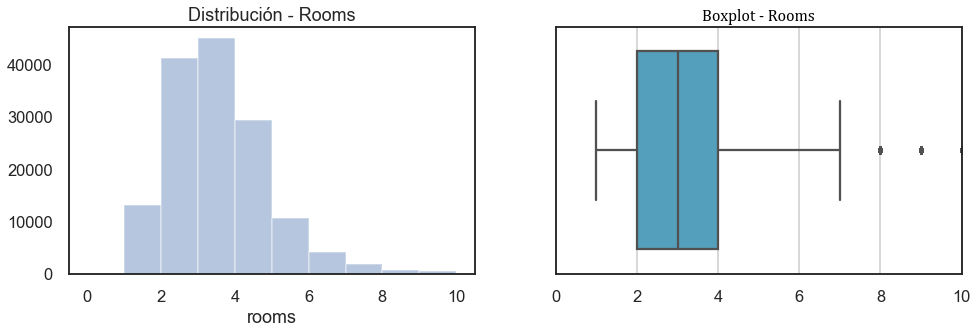

In [37]:
# ***********
#    Rooms
# ***********
plt.figure(figsize = (16,10))
plt.subplot(2,2,1)
sns.distplot(data6['rooms'],bins=10,kde=False,hist=True,hist_kws={"range": [0,10]})
plt.title('Distribución - Rooms')

plt.subplot(2,2,2)
sns.boxplot(x=data6[['rooms']], palette= 'GnBu_d')
plt.title('Boxplot - Rooms',fontdict = title_font)
plt.grid(axis='x')
plt.xlim(0,10)
plt.show();

In [38]:
# Llamo a la función elimino_outliers pasandole el feature Rooms y obtengo los outliers
rooms_outliers = elimino_outliers(data6,'rooms')
rooms_outliers.sum()

1447

In [39]:
# Filtro el dataset con la mascara de los outliers de rooms
data6 = data6[~rooms_outliers]
data6.shape

(145213, 19)

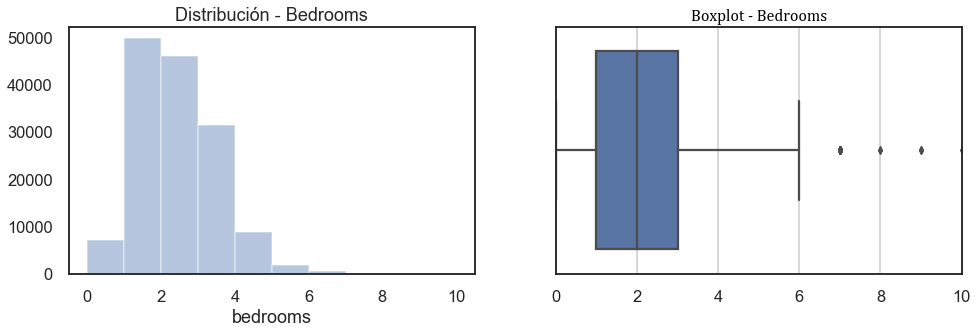

In [40]:
# *************
#   Bedrooms   
# *************
plt.figure(figsize = (16,10))
plt.subplot(2,2,1)
sns.distplot(data6['bedrooms'],bins=10,kde=False,hist=True,hist_kws={"range": [0,10]})
plt.title('Distribución - Bedrooms')

plt.subplot(2,2,2)
sns.boxplot(x=data6[['bedrooms']])
plt.title('Boxplot - Bedrooms',fontdict = title_font)
plt.grid(axis='x')
plt.xlim(0,10)
plt.show();

In [41]:
# Llamo a la función elimino_outliers pasandole el feature Bedrooms y obtengo los outliers
bedrooms_outliers = elimino_outliers(data6,'bedrooms')
bedrooms_outliers.sum()

36

In [42]:
# Filtro el dataset con la mascara de los outliers de bedrooms
data6 = data6[~bedrooms_outliers]
data6.shape

(145177, 19)

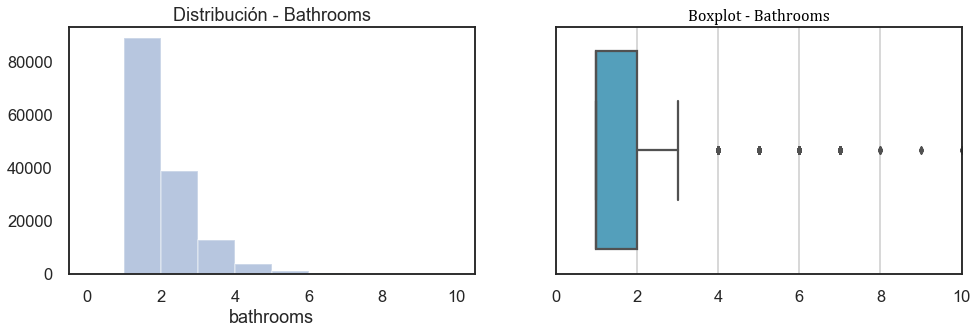

In [43]:
# *************
#   Bathrooms
# *************
plt.figure(figsize = (16,10))
plt.subplot(2,2,1)
sns.distplot(data6['bathrooms'],bins=10,kde=False,hist=True,hist_kws={"range": [0,10]})
plt.title('Distribución - Bathrooms')

plt.subplot(2,2,2)
sns.boxplot(x=data6[['bathrooms']], palette= 'GnBu_d')
plt.title('Boxplot - Bathrooms',fontdict = title_font)
plt.grid(axis='x')
plt.xlim(0,10)
plt.show();

In [44]:
# Llamo a la función elimino_outliers pasandole el feature Bathrooms y obtengo los outliers
bathrooms_outliers = elimino_outliers(data6,'bathrooms')
bathrooms_outliers.sum()

4894

In [45]:
# Filtro el dataset con la mascara de los outliers de bathrooms
data6 = data6[~bathrooms_outliers]
data6.shape

(140283, 19)

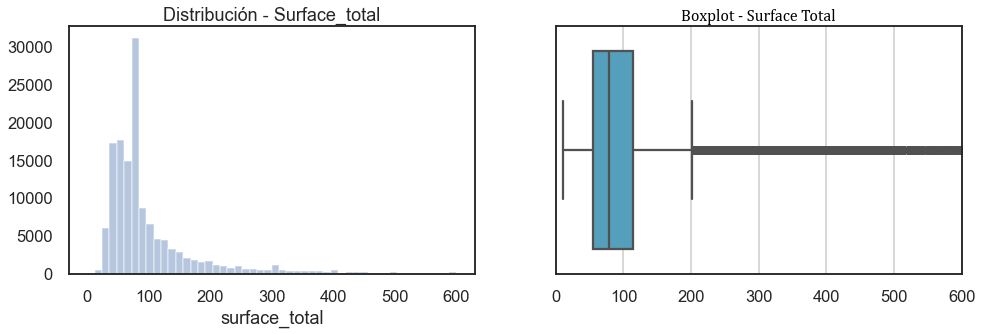

In [46]:
# *******************
#   Surface_total
# *******************
plt.figure(figsize = (16,10))
plt.subplot(2,2,1)
sns.distplot(data6['surface_total'],bins=50,kde=False,hist=True,hist_kws={"range": [0,600]})
plt.title('Distribución - Surface_total')

plt.subplot(2,2,2)
sns.boxplot(x=data6[['surface_total']], palette= 'GnBu_d')
plt.title('Boxplot - Surface Total',fontdict = title_font)
plt.grid(axis='x')
plt.xlim(0,600)
plt.show();

In [47]:
# Llamo a la función elimino_outliers pasandole el feature surface_total y obtengo los outliers
sup_tot_outliers = elimino_outliers(data6,'surface_total')
sup_tot_outliers.sum()

15757

* Debido a que son muchas instancias antes de filtrarlos analizaré los mismos.

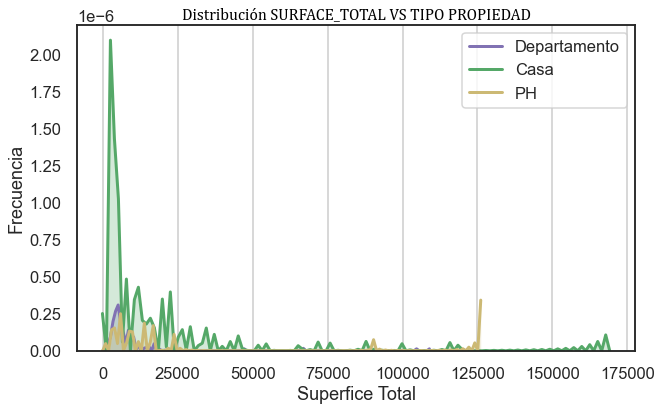

In [48]:
# Distribución de la Superfice total de acuerdo al tipo de propiedad (no considero Otros ya que agrupo varios tipos de propiedad)
fig, ax = plt.subplots(figsize=(10,6))
ax= sns.distplot(a=data6[data6.property_type_n == 0].surface_total, hist=False, label= 'Departamento', 
             kde_kws={'shade': True, 'lw': 3, 'color': 'm' } )
ax= sns.distplot(a=data6[data6.property_type_n == 2].surface_total,  hist=False, label= 'Casa', 
             kde_kws={'shade': True, 'lw': 3, 'color': 'g' })
ax= sns.distplot(a=data6[data6.property_type_n == 1].surface_total, hist=False, label= 'PH', 
             kde_kws={'shade': True, 'lw': 3, 'color': 'y' })
ax.set_xlabel('Superfice Total')
ax.set_ylabel('Frecuencia')
plt.title('Distribución SURFACE_TOTAL VS TIPO PROPIEDAD' ,fontdict = title_font)

plt.grid(axis='x')
plt.show();

In [49]:
data6[sup_tot_outliers].groupby('property_type_n').agg({'surface_total':['mean', 'max', 'min']}).reset_index()

property_type_n surface_total                 
                           mean       max    min
0               0    735.538701  108960.0  203.0
1               1    716.056136  126062.0  203.0
2               2    784.559996  169000.0  203.0
3               3   4408.982510  193549.0  203.0

* Después de analizar la distribución de la superficie total con respecto a los tipos de propiedad concluyo que realmente los valores atípicos correspondientes a la surface_total los descarto ya que no encuentro una manera óptima para mantenerlo sin modificar la esencia del dataset.

In [50]:
# Filtro el dataset con la mascara de los outliers de surface_total
data6 = data6[~sup_tot_outliers]
data6.shape

(124526, 19)

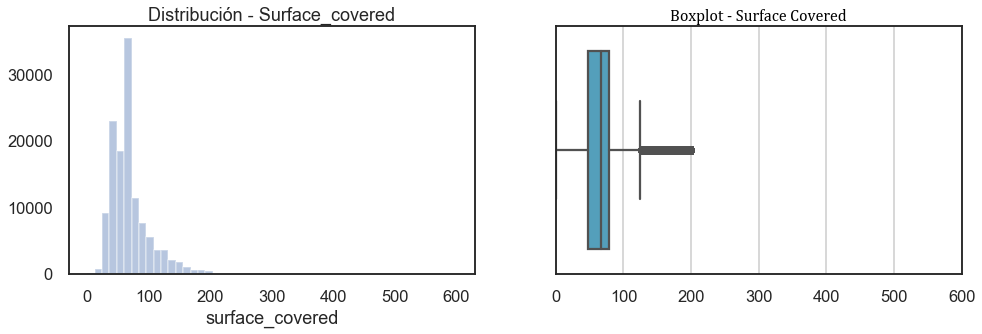

In [51]:
# **********************
#    Surface_covered
# **********************
plt.figure(figsize = (16,10))
plt.subplot(2,2,1)
sns.distplot(data6['surface_covered'],bins=50,kde=False,hist=True,hist_kws={"range": [0,600]})
plt.title('Distribución - Surface_covered')

plt.subplot(2,2,2)
sns.boxplot(x=data6[['surface_covered']], palette= 'GnBu_d')
plt.title('Boxplot - Surface Covered',fontdict = title_font)
plt.grid(axis='x')
plt.xlim(0,600)
plt.show();

In [52]:
# Llamo a la función elimino_outliers pasandole el feature surface_covered y obtengo los outliers
sup_cub_outliers = elimino_outliers(data6,'surface_covered')
sup_cub_outliers.sum()

7911

In [53]:
# Filtro el dataset con la mascara de los outliers de surface_covered
data6 = data6[~sup_cub_outliers]
data6.shape

(116615, 19)

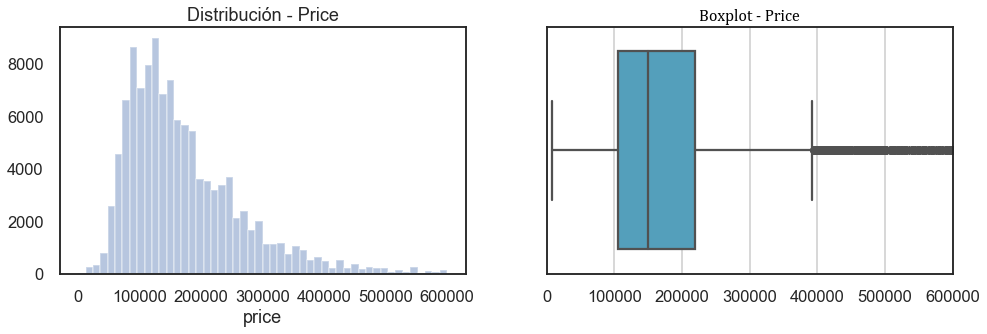

In [54]:
# *********
#   Price
# *********
plt.figure(figsize = (16,10))
plt.subplot(2,2,1)
sns.distplot(data6['price'],bins=50,kde=False,hist=True,hist_kws={"range": [0,600000]})
plt.title('Distribución - Price')

plt.subplot(2,2,2)
sns.boxplot(x=data6[['price']], palette= 'GnBu_d')
plt.title('Boxplot - Price',fontdict = title_font)
plt.grid(axis='x')
plt.xlim(0,600000)
plt.show();

In [55]:
# Llamo a la función elimino_outliers pasandole el feature price y obtengo los outliers
price_outliers = elimino_outliers(data6,'price')
price_outliers.sum()

5053

In [56]:
# Filtro el dataset con la mascara de los outliers de price
data6 = data6[~price_outliers]

In [57]:
# Mi dataset final sin OUTLIERS
data6.shape

(111562, 19)

 **4. Escalado de los datos**
 
   Aplicaré el escalado de todos mis datos mediante el uso de la librería StanderScaler() excepto mi feature objetivo `price`. Este paso es fundamental ya al tener variables con escalas muy diferentes, como ser la cantidad de habitaciones baños y piezas difieren mucho de la superficie total por lo tanto llevo todas las variables a una misma unidad y de esta manera ayudo a mejorar el rendimiento del modelo.

In [58]:
data6.drop(['price'],axis=1).head(10)

,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type_n,l2_n,B.Almagro,B.Belgrano,B.Caballito,B.La Matanza,B.La Plata,B.Otros,B.Palermo,B.Pilar,B.Recoleta,B.Tigre,B.Villa Crespo
1,2.0,1.0,2.0,70.0,58.0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.0,1.0,45.0,45.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2.0,1.0,1.0,85.0,50.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2.0,1.0,1.0,50.0,35.0,1,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,1.0,1.0,56.0,56.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,2.0,1.0,1.0,70.0,70.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,2.0,1.0,1.0,70.0,70.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,1.0,1.0,1.0,45.0,37.0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,1.0,1.0,1.0,45.0,37.0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10,2.0,1.0,2.0,66.0,49.0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [59]:
sta_scale = StandardScaler()
data7 = pd.DataFrame(sta_scale.fit_transform(data6.drop(['price'],axis=1)))

In [60]:
data7.shape

(111562, 18)

In [61]:
data7.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.641554,-0.731206,1.318890,-0.071094,-0.174671,1.140774,-0.613959,-0.258384,-0.211367,-0.230105,-0.162263,-0.164777,0.929966,-0.310969,-0.140744,-0.186141,-0.254892,-0.238786
1,-0.641554,-0.731206,-0.571372,-0.915605,-0.793248,1.140774,-0.613959,-0.258384,-0.211367,-0.230105,-0.162263,-0.164777,-1.075308,3.215752,-0.140744,-0.186141,-0.254892,-0.238786
2,-0.641554,-0.731206,-0.571372,0.435612,-0.555334,1.140774,-0.613959,-0.258384,-0.211367,-0.230105,-0.162263,-0.164777,-1.075308,3.215752,-0.140744,-0.186141,-0.254892,-0.238786


In [62]:
data7.rename(columns={0:'rooms',1:'bedrooms',2:'bathrooms',3:'surface_total',4:'surface_covered',
                       5:'property_type_n',6:'l2_n',7:'B.Almagro',8:'B.Belgrano',9:'B.Caballito',10:'B.La Matanza',
                       11:'B.La Plata',12:'B.Otros',13:'B.Palermo',14:'B.Pilar',15:'B.Recoleta',16:'B.Tigre',
                       17:'B.Villa Crespo'}, inplace=True)

In [63]:
data7.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type_n,l2_n,B.Almagro,B.Belgrano,B.Caballito,B.La Matanza,B.La Plata,B.Otros,B.Palermo,B.Pilar,B.Recoleta,B.Tigre,B.Villa Crespo
0,-0.641554,-0.731206,1.318890,-0.071094,-0.174671,1.140774,-0.613959,-0.258384,-0.211367,-0.230105,-0.162263,-0.164777,0.929966,-0.310969,-0.140744,-0.186141,-0.254892,-0.238786
1,-0.641554,-0.731206,-0.571372,-0.915605,-0.793248,1.140774,-0.613959,-0.258384,-0.211367,-0.230105,-0.162263,-0.164777,-1.075308,3.215752,-0.140744,-0.186141,-0.254892,-0.238786
2,-0.641554,-0.731206,-0.571372,0.435612,-0.555334,1.140774,-0.613959,-0.258384,-0.211367,-0.230105,-0.162263,-0.164777,-1.075308,3.215752,-0.140744,-0.186141,-0.254892,-0.238786
3,-0.641554,-0.731206,-0.571372,-0.746703,-1.269077,1.140774,1.473843,-0.258384,-0.211367,-0.230105,-0.162263,6.068810,-1.075308,-0.310969,-0.140744,-0.186141,-0.254892,-0.238786
4,-0.641554,-0.731206,-0.571372,-0.544021,-0.269837,1.140774,-0.613959,-0.258384,-0.211367,-0.230105,-0.162263,-0.164777,-1.075308,-0.310969,-0.140744,-0.186141,-0.254892,4.187846


## Defino mi  X e y, es decir, mis datos de entrenamiento y mi variable objetivo que quiero predecir para todo mi Proyecto_02

In [64]:
X = data7
y = data6['price']

###      ARBOL DE DECISION

 Para poder comparar con el modelo del entregable 1 aplicaré los mismos filtro que a continuación pasare a detallar y como último punto me quedaré con los siguientes features **['rooms','bedrooms','bathrooms','surface_covered','surface_total', 'price']** que son los mismos con los que entrené los modelos del Entregable 1. 

1. Selecciona aquellas propiedades en Capital Federal y cuyo tipo de propiedad es Departamento, PH o Casa.
1. Selecciona aquellas propiedades cuya superficie total es menor a 1000 m2 y mayor a 15 m2.
1. Selecciona aquellas propiedades cuya precio es menor 4000000 dólares.
Para ello deberé realizar una transformación especial de los datos (EDA) ya que todo mi preprocesamiento anterior lo realicé sobre todo el data **************

In [65]:
# Primer Filtro del Entregable 1 (línea código 14)
data_m=data1[(data1.l2=='Capital Federal') & (data1.property_type.isin(['Departamento','Casa','PH']))]
data_m.shape

(91485, 9)

In [66]:
# Segundo Filtro del Entregable 1 (línea código 18)
data_m = data_m[(data_m.surface_total >= 15) & (data_m.surface_total <= 1000)]
data_m.shape

(82405, 9)

In [67]:
# Tercer Filtro del Entregable 1 (línea código 19)
data_m = data_m[(data_m.price <= 4000000)]
data_m.shape

(82373, 9)

In [68]:
data_m1 = data_m[['rooms','bedrooms','bathrooms','surface_covered','surface_total','price']]
data_m1.head(10)

,rooms,bedrooms,bathrooms,surface_covered,surface_total,price
0,7.0,7.0,2.0,140.0,140.0,153000.0
1,2.0,1.0,2.0,58.0,70.0,159000.0
2,2.0,1.0,1.0,45.0,45.0,125000.0
3,2.0,1.0,1.0,50.0,85.0,295000.0
5,2.0,1.0,1.0,56.0,56.0,150000.0
6,2.0,1.0,1.0,70.0,70.0,159500.0
7,2.0,1.0,1.0,70.0,70.0,159500.0
8,1.0,1.0,1.0,37.0,45.0,89000.0
9,1.0,1.0,1.0,37.0,45.0,89000.0
10,2.0,1.0,2.0,49.0,66.0,170000.0


In [69]:
# Reseteamos los indices ya que mi dataset original se modifico después de aplicar los filtros
data_m1 = data_m1.reset_index()
data_m1.head(10)

,index,rooms,bedrooms,bathrooms,surface_covered,surface_total,price
0,0,7.0,7.0,2.0,140.0,140.0,153000.0
1,1,2.0,1.0,2.0,58.0,70.0,159000.0
2,2,2.0,1.0,1.0,45.0,45.0,125000.0
3,3,2.0,1.0,1.0,50.0,85.0,295000.0
4,5,2.0,1.0,1.0,56.0,56.0,150000.0
5,6,2.0,1.0,1.0,70.0,70.0,159500.0
6,7,2.0,1.0,1.0,70.0,70.0,159500.0
7,8,1.0,1.0,1.0,37.0,45.0,89000.0
8,9,1.0,1.0,1.0,37.0,45.0,89000.0
9,10,2.0,1.0,2.0,49.0,66.0,170000.0


In [70]:
data_m1.drop(['index'], axis=1, inplace=True)
data_m1.head()

,rooms,bedrooms,bathrooms,surface_covered,surface_total,price
0,7.0,7.0,2.0,140.0,140.0,153000.0
1,2.0,1.0,2.0,58.0,70.0,159000.0
2,2.0,1.0,1.0,45.0,45.0,125000.0
3,2.0,1.0,1.0,50.0,85.0,295000.0
4,2.0,1.0,1.0,56.0,56.0,150000.0


### Preprocesamiento de los Datos (EDA)

Solamente aplicaré los siguientes pasos en mi EDA ya que el dataset solo tiene variables numéricas: 

1. Imputación de valores faltantes (SimpleImputer)

1. Outliers (Rango Intercuartílico)

1. Escalado de los datos (StanderScaler)

1. Imputación de valores faltantes (SimpleImputer)

In [71]:
data_m1.isnull().sum()

rooms                0
bedrooms             0
bathrooms          880
surface_covered    517
surface_total        0
price                0
dtype: int64

In [72]:
imputer_m= SimpleImputer(missing_values=np.nan, strategy='median')
data_m2= pd.DataFrame(imputer_m.fit_transform(data_m1[['bathrooms','surface_covered']]),
                      columns=data_m1[['bathrooms','surface_covered']].columns)

In [73]:
data_m2.isnull().sum()

bathrooms          0
surface_covered    0
dtype: int64

In [74]:
data_m1.drop(['bathrooms','surface_covered'], axis = 'columns', inplace=True)
data_m3=pd.concat([data_m1, data_m2], axis=1, sort=False)

In [75]:
data_m3.head()

,rooms,bedrooms,surface_total,price,bathrooms,surface_covered
0,7.0,7.0,140.0,153000.0,2.0,140.0
1,2.0,1.0,70.0,159000.0,2.0,58.0
2,2.0,1.0,45.0,125000.0,1.0,45.0
3,2.0,1.0,85.0,295000.0,1.0,50.0
4,2.0,1.0,56.0,150000.0,1.0,56.0


1. Outliers (Rango Intercuartílico)

In [76]:
# Rooms 
# Llamo a la función elimino_outliers pasandole el feature Rooms y obtengo los outliers
rooms_out = elimino_outliers(data_m3,'rooms')
# Filtro el dataset con la mascara de los outliers de rooms
data_m3 = data_m3[~rooms_out]
data_m3.shape

(81735, 6)

In [77]:
# Bedrooms
# Llamo a la función elimino_outliers pasandole el feature Bedrooms y obtengo los outliers
bedrooms_out = elimino_outliers(data_m3,'bedrooms')
# Filtro el dataset con la mascara de los outliers de bedrooms
data_m3 = data_m3[~bedrooms_out]
data_m3.shape

(81715, 6)

In [78]:
# Bathrooms 
# Llamo a la función elimino_outliers pasandole el feature Bathrooms y obtengo los outliers
bathrooms_out = elimino_outliers(data_m3,'bathrooms')
# Filtro el dataset con la mascara de los outliers de bathrooms
data_m3 = data_m3[~bathrooms_out]
data_m3.shape

(79080, 6)

In [79]:
# Surface_total
# Llamo a la función elimino_outliers pasandole el feature Surface_total y obtengo los outliers
sup_tot_out = elimino_outliers(data_m3,'surface_total')
# Filtro el dataset con la mascara de los outliers de surface_total
data_m3 = data_m3[~sup_tot_out]
data_m3.shape

(73639, 6)

In [80]:
# Surface_covered
# Llamo a la función elimino_outliers pasandole el feature Surface_covered y obtengo los outliers
sup_cub_out = elimino_outliers(data_m3,'surface_covered')
# Filtro el dataset con la mascara de los outliers de surface_covered
data_m3 = data_m3[~sup_cub_out]
data_m3.shape

(70636, 6)

In [81]:
# Price
# Llamo a la función elimino_outliers pasandole el feature Price y obtengo los outliers
price_out = elimino_outliers(data_m3,'price')
# Filtro el dataset con la mascara de los outliers de price
data_m3 = data_m3[~price_out]
data_m3.shape

(67522, 6)

1. Escalado de los datos (StanderScaler) No escalo mi feature objetivo `price`

In [82]:
data_m3.head()

,rooms,bedrooms,surface_total,price,bathrooms,surface_covered
1,2.0,1.0,70.0,159000.0,2.0,58.0
2,2.0,1.0,45.0,125000.0,1.0,45.0
3,2.0,1.0,85.0,295000.0,1.0,50.0
4,2.0,1.0,56.0,150000.0,1.0,56.0
5,2.0,1.0,70.0,159500.0,1.0,70.0


In [83]:
sta_scale_m = StandardScaler()
data_mf = pd.DataFrame(sta_scale_m.fit_transform(data_m3.drop(['price'],axis=1)))

In [84]:
data_mf.head()

,0,1,2,3,4
0,-0.688098,-0.906276,0.040566,1.337746,-0.112310
1,-0.688098,-0.906276,-0.796743,-0.570066,-0.649072
2,-0.688098,-0.906276,0.542951,-0.570066,-0.442625
3,-0.688098,-0.906276,-0.428327,-0.570066,-0.194889
4,-0.688098,-0.906276,0.040566,-0.570066,0.383162


In [85]:
data_mf.rename(columns={0:'rooms',1:'bedrooms',2:'surface_total',3:'bathrooms',4:'surface_covered'},
               inplace=True)                    

## Machine Learning 

1. Defino mi set de entrenamineto y de test
2. Entreno un Arbol de Decisión con los hiperparametros por default y obtengo error 
3. Elijo el mejor valor de mi hiperparámetro (max_depth) y vuelvo a entrenar


In [86]:
X_m = data_mf
y_m = data_m3['price']

In [87]:
# Defino los datos para de training and testing
X_train, X_test, y_train, y_test = train_test_split( X_m, y_m, test_size=0.30, random_state=42)

In [88]:
# ***********************************
#   MODELO = DecissionTreeRegressor
# ***********************************

# Defino las listas vacias para los valores de r2_score
lista_r2_train = []
lista_r2_test = []

# Defino la lista de valores de max_depth que vamos a explorar
max_depths = [1,4,8,9,10,12,14,16,20,30]

# Genero un loop sobre los distintos valores de profundidad 
for max_depth in max_depths:
    
    # Defino el modelo el valor profundidad del arbol deseado
    clft = DecisionTreeRegressor(max_depth = max_depth ,random_state=42)
  
    # Entreno el modelo
    clft.fit(X_train,y_train)
    
    # Predigo y evaluo sobre el set de entrenamiento
    y_train_pred = clft.predict(X_train)
    train_r2= r2_score(y_train, y_train_pred)
    print(f'Profundidad del Árbol: {max_depth} ')
    print(f'Error R2 en Train: {train_r2}')
    
    
    # Predigo y evaluo sobre el set de evaluación
    y_test_pred = clft.predict(X_test)
    test_r2 = r2_score(y_test,y_test_pred)
    print(f'Error R2 en Test: {test_r2}')
    
    # Agrego la información a las listas
    lista_r2_train.append(train_r2)
    lista_r2_test.append(test_r2)

Profundidad del Árbol: 1 
Error R2 en Train: 0.41550656032538025
Error R2 en Test: 0.422631528425531
Profundidad del Árbol: 4 
Error R2 en Train: 0.589135467346462
Error R2 en Test: 0.5976746254916796
Profundidad del Árbol: 8 
Error R2 en Train: 0.6433866208487639
Error R2 en Test: 0.6418465321059561
Profundidad del Árbol: 9 
Error R2 en Train: 0.6590649561402858
Error R2 en Test: 0.6521767041048282
Profundidad del Árbol: 10 
Error R2 en Train: 0.6794957581206165
Error R2 en Test: 0.6598627238406636
Profundidad del Árbol: 12 
Error R2 en Train: 0.7212129289223017
Error R2 en Test: 0.6708588673706912
Profundidad del Árbol: 14 
Error R2 en Train: 0.7569970808238415
Error R2 en Test: 0.678867235455223
Profundidad del Árbol: 16 
Error R2 en Train: 0.7861519068873634
Error R2 en Test: 0.6785073622745588
Profundidad del Árbol: 20 
Error R2 en Train: 0.8161886018527532
Error R2 en Test: 0.681453405083342
Profundidad del Árbol: 30 
Error R2 en Train: 0.8256805665593236
Error R2 en Test: 0.6793

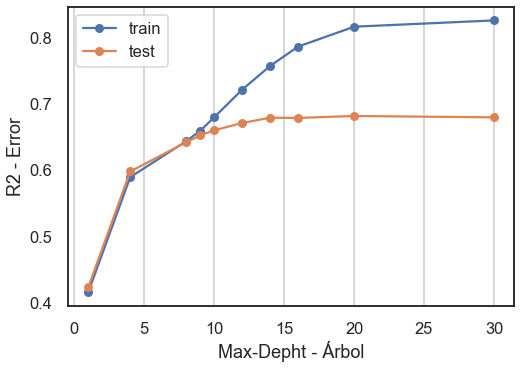

In [89]:
plt.plot(max_depths,lista_r2_train,'o-',label='train' )
plt.plot(max_depths,lista_r2_test,'o-',label='test')
plt.legend()
plt.xlabel('Max-Depht - Árbol')
plt.ylabel('R2 - Error')

plt.grid(axis='x')
plt.show();

Error R2 en Train: 0.7397643897604042
Raíz del error cuadrático medio en Train: 39641.02633575552
Error R2 en Test: 0.6727694271292337
Raíz del error cuadrático medio en Test: 44760.84475410463


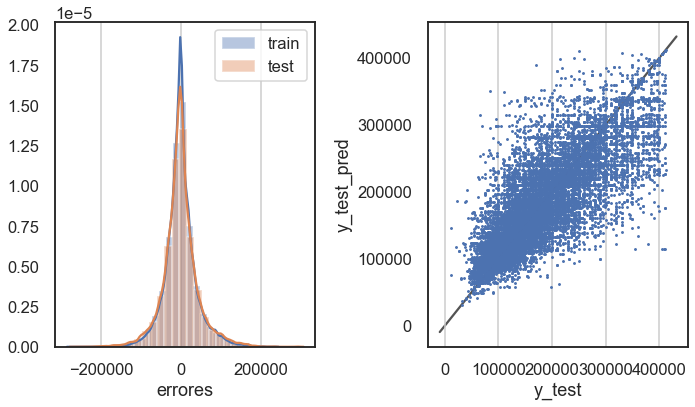

In [90]:
# Mido la precisión del modelo a través de la relación entre el valor real vs el valor predecido 

# Defino el modelo con el Hiperpáremtro elegido max_depth = 13
clft = DecisionTreeRegressor(max_depth= 13 , random_state=30)

# Entreno el modelo
clft.fit(X_train,y_train)

# Evaluo el modelo
evaluo_regresion(clft, X,y, X_train, X_test, y_train,y_test) 

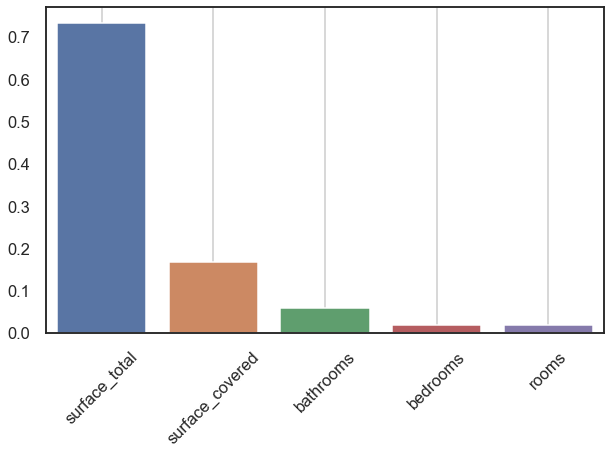

In [91]:
importances = clft.feature_importances_
columns = X_train.columns
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(columns[indices], importances[indices], order=columns[indices])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.grid(axis='x')
plt.show();

## Conclusión punto A
 
     Proyecto_01 --> Profundidad del Árbol: 6 - Error R2 en Train: 0.735 - Error R2 en Test: 0.691
 
     Proyecto_02 --> Profundidad del Árbol: 13 - Error R2 en Train: 0.739 - Error R2 en Test: 0.672

* Lo primero que detecto es la diferencia entre el hiperparámetro `max_depth`. En el proyecto_01 elegí como mi óptimo max_depth igual a **6** mientras que en el proyecto_02, después de aplicar EDA al dataset y mantener las mismas condiciones (filtros aplicados) el max_depth óptimo fue **13**. Infiero que esto significa que con el dataset del segundo proyecto el modelo de arbol necesito hacer más preguntas para poder obtener una mejor predicción considero que la causa de esto se debe a que los datos estaban más limpios (procesados) que los del proyecto_01.
* Con respecto al desempeño (R2) observo que obtuve casi el mismo error tanto en train como en test para ambos proyectos inclusive levemente más bajo en test para el proyecto_02.
* Analizando las Curvas de Complejidad obtendias con cada uno de los Proyectos(01 y 02) observo que en Proyecto_01 había una diferencia desde la profundidad del arbol (max_depth) igual a 1 entre el train y el test mientras que en Proyecto_02 hasta un max_depth=9 los datos de train y el test predicían igual esto vuelve a confirmar mi teoría que necesito más profundiad para lograr una mejor predicción.
* Considero que para obtener una mejora sustancial debería incluir más features en mi dataset y así el modelo contaría con más información para mejorar mucho más su predicción.

## PARTE B - Modelos Avanzados

Elige dos de los modelos avanzados vistos (en el caso de regresión, considera una regresión lineal con atributos polinómicos y regularización). Entrénalos y evalúalos con sus argumentos por defecto. No te olvides de hacer un train/test split y usar Validación Cruzada.

Optimiza sus hiperparámetros mediante Validación Cruzada y Grid Search o Random Search.

Compara el desempeño de los nuevos modelos entre sí y con el modelo de la Parte A. ¿Cuál elegirías? Justifica.

### Random Search

Utilizaré la estrategía **Aleatoria** para la optimización de hiperparámetros mediante la aplicación de la función de Scikit-Learn **RandomizedSearchCV** que ya incluye la cross_validate **CV**. Elijo este estrategia porque considero que computacionalmente es mejor ya que al crear la grilla realiza combinaciones aleatorias entre los rangos especificados para los hiperparámetros fijando inicialemete el número de configuraciones aleatorias que queremos probar en la grilla de parámetros.

### Modelo Elegidos:

1. Polinomial
2. Ridge
3. Lasso
4. RandomForest

In [92]:
# Defino mis datos de entrenamiento 'X' y la variable que quiero predecir 'y'
X = data7
y = data6['price']
X.shape

(111562, 18)

* Primero que todo genero una mapa de calor del nuevo dataset para analizar con mi nuevo dataset la correlación de los features.

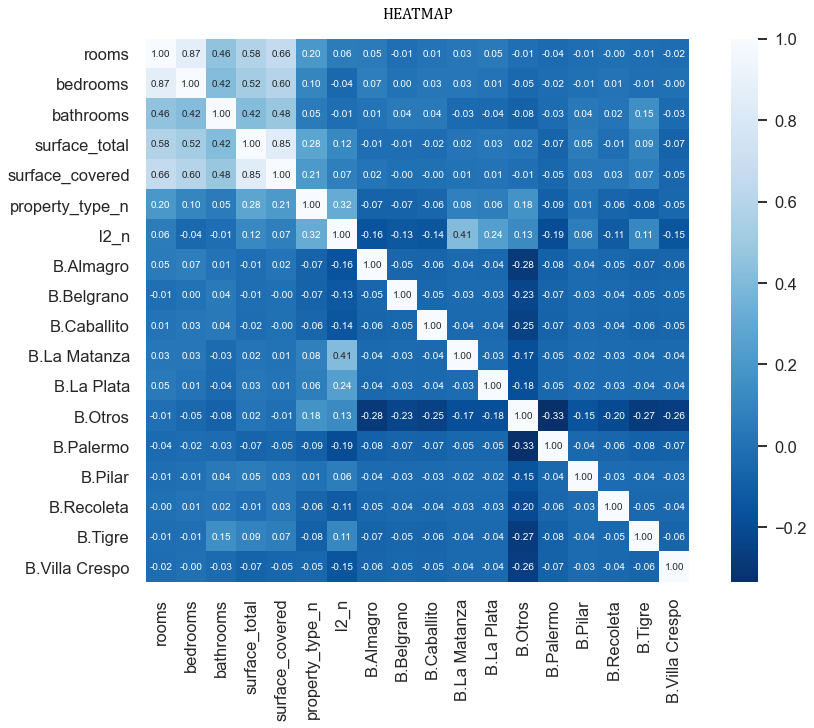

In [93]:
# HEATMAP

corr = X.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},
           xticklabels= X.columns, 
           yticklabels= X.columns,
           cmap='Blues_r',)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, size= 'medium', fontsize = 8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=60, size= 'medium', fontsize = 8)
plt.title('HEATMAP', fontdict= title_font, pad= 20)
plt.show();


In [94]:
# Visualizo las columnas positivamente correlacionadas en orden creciente de correlación
corr    = data6.corr()
pos_cor = corr['price'] >0
neg_cor = corr['price']  <0
corr['price'][pos_cor].sort_values(ascending = False)

price              1.000000
surface_covered    0.570223
bathrooms          0.545148
rooms              0.495663
surface_total      0.491606
bedrooms           0.460266
B.Palermo          0.151687
B.Belgrano         0.134970
B.Recoleta         0.131654
B.Tigre            0.129881
B.Caballito        0.037882
B.Almagro          0.016814
Name: price, dtype: float64

In [95]:
# Visualizo las columnas negativamente correlacionadas en orden creciente de correlación
corr['price'][neg_cor].sort_values()

l2_n              -0.222265
B.Otros           -0.184796
B.La Plata        -0.118670
B.La Matanza      -0.085816
B.Pilar           -0.038254
B.Villa Crespo    -0.032768
property_type_n   -0.004377
Name: price, dtype: float64

In [96]:
# Dividimos los datos en Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=30)

### Polynomial Features

A través de la función `PolynomialFeatures` la cual me permite convertir mi dataset original en uno nuevo dataset cuyas variables o términos tienen un orden superior, es decir, lo transformo en un polinomio de grado n. Esta función es útil cuando se observa que la relación entre `X` e `y` no es del todo lineal, graficamente mis datos no represenan una recta por lo tanto lo convierto en un polinomio de tantos grados como necesita de manera que me definan mejor mi modelo de datos. Para este modelo opto por un `polinomio de grado 2`, ya que al tener tantos features realmente mi modelo se complejiza bastante a medida que aumento el grado del polinomio. Probé con uno de grado 3 el cual tuvo un tiempo mayor de procesamiento pero su rendimiento fue el mismo que me arrojo el de grado 2 por ese motivo justifico mi elección.

In [97]:
# Convierto el dataset en un polinomio de grado 2
poly = PolynomialFeatures(degree=2 , include_bias=False) 
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
print(X_train_poly.shape, X_test_poly.shape)

(78093, 189) (33469, 189)


### Regularización Ridge L1

Error R2 en Train: 0.599363299987814
Raíz del error cuadrático medio en Train: 48457.21987116681
Error R2 en Test: 0.6036077345743446
Raíz del error cuadrático medio en Test: 48354.275783772355


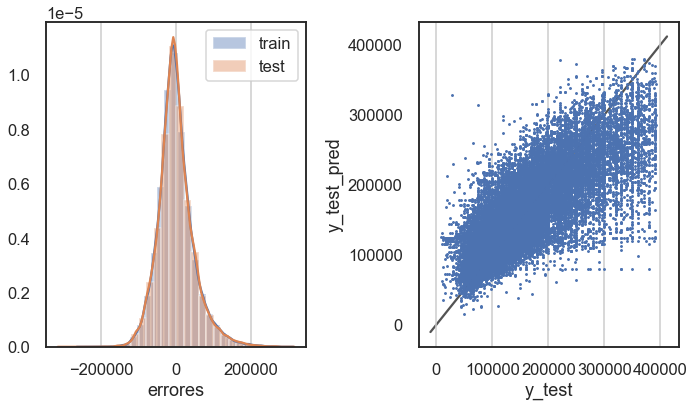

In [98]:
# Defino el modelo
reg_L1 = Ridge(alpha=5, random_state=1 )

# Entreno el modelo
reg_L1.fit(X_train_poly,y_train)

# Predigo y Evaluo el modelo
evaluo_regresion(reg_L1, X,y, X_train_poly, X_test_poly, y_train, y_test)

#### Optimización de Hiperparámteros del Modelo Ridge con RandomSearchCV

In [99]:
# Defino la grillo del RandomSearchCV
param_dist = {'alpha':[0, 1, 10, 20, 50, 100]}
              
# Defino mi estrategia con RandomSearchCV
modelo_L1 = RandomizedSearchCV(reg_L1, param_dist ,n_iter=20, cv=5, n_jobs= -1) 

# Entreno el modelo
modelo_L1.fit(X_train_poly,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Ridge(alpha=5, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=1, solver='auto', tol=0.001),
                   iid='deprecated', n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': [0, 1, 10, 20, 50, 100]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [100]:
print('Mejores Hiperparámetros: '+str(modelo_L1.best_params_))
print('Mejor Score:'+str(modelo_L1.best_score_)+'\n')

scores_ridge = pd.DataFrame(modelo_L1.cv_results_)
scores_ridge

Mejores Hiperparámetros: {'alpha': 100}
Mejor Score:0.5976539955499236



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.116955,1.023404,0.018396,0.006972,0,{'alpha': 0},0.584049,0.590555,0.583336,0.584006,0.590771,0.586543,0.003374,6
1,0.897461,0.016508,0.018400,0.001959,1,{'alpha': 1},0.595751,0.597052,0.602820,0.595818,0.596793,0.597647,0.002638,5
2,0.965451,0.068933,0.015198,0.002994,10,{'alpha': 10},0.595757,0.597053,0.602819,0.595815,0.596795,0.597648,0.002637,4
3,0.758276,0.049082,0.016800,0.003918,20,{'alpha': 20},0.595764,0.597054,0.602819,0.595813,0.596798,0.597650,0.002635,3
4,0.767079,0.026935,0.017599,0.007419,50,{'alpha': 50},0.595781,0.597056,0.602815,0.595804,0.596806,0.597652,0.002632,2
5,0.849111,0.140438,0.011199,0.001600,100,{'alpha': 100},0.595806,0.597056,0.602806,0.595787,0.596815,0.597654,0.002627,1


Error R2 en Train: 0.59935801245338
Raíz del error cuadrático medio en Train: 48457.539635149056
Error R2 en Test: 0.6035846102205344
Raíz del error cuadrático medio en Test: 48355.686186007595


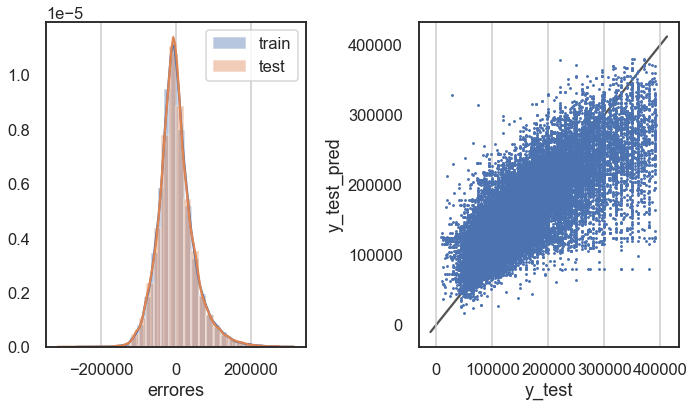

In [101]:
# Defino el modelo con los mejores Hiperpáremtros obtenidos con RandomSeachCV{alpha=100}
reg_L1n = Ridge(alpha= 100,  random_state=1)

# Entreno  el modelo 
reg_L1n.fit(X_train_poly,y_train)

# Predigo y evaluo el modelo
evaluo_regresion(reg_L1n, X,y, X_train_poly, X_test_poly, y_train, y_test)

In [102]:
print ('Pendientes: ', reg_L1n.coef_)
print ('Ordenada: ',reg_L1n.intercept_)

Pendientes:  [ 5.60985755e+03  7.61937754e+03  2.11310816e+04  2.72445565e+04
  7.99348182e+03 -2.03209990e+04 -4.84219127e+03  1.22498992e+02
  4.22484288e+02  1.80396689e+02 -6.35098894e+01 -1.74585766e+02
 -1.22336944e+03  1.33618842e+03 -9.19549572e+01  2.88794809e+02
  2.21896585e+02  9.87125406e+01 -1.58961955e+03 -5.19952437e+03
 -2.13068723e+03  8.38700896e+02  3.73156473e+03  3.79553841e+03
  1.34005278e+03  1.13897028e+03  9.67997198e+02 -3.05100923e+02
 -1.48934718e+03 -1.14612618e+03  3.01695682e+02  2.09991509e+03
 -5.75873182e+02  6.37541246e+02 -1.55414528e+03 -1.74786593e+03
  1.40354367e+03 -1.07714479e+02  2.90795388e+02 -6.69110431e+02
 -3.86110490e+02 -1.42845411e+03  9.61158661e+02  2.37217424e+02
  1.84795027e+03  1.78409240e+03  1.12809405e+03 -9.80340978e+02
 -2.93953733e+03 -2.33999339e+03 -8.24764482e+02  8.27475718e+02
  1.98305401e+03  5.87742585e+02 -1.73120291e+03 -1.11876010e+03
 -1.12935580e+03  1.78856442e+03 -4.93610686e+02 -3.50721035e+02
 -3.91036500

### Regularización Lasso L2

Error R2 en Train: 0.5993627400347777
Raíz del error cuadrático medio en Train: 48457.2537344623
Error R2 en Test: 0.6036017818881224
Raíz del error cuadrático medio en Test: 48354.63885436647


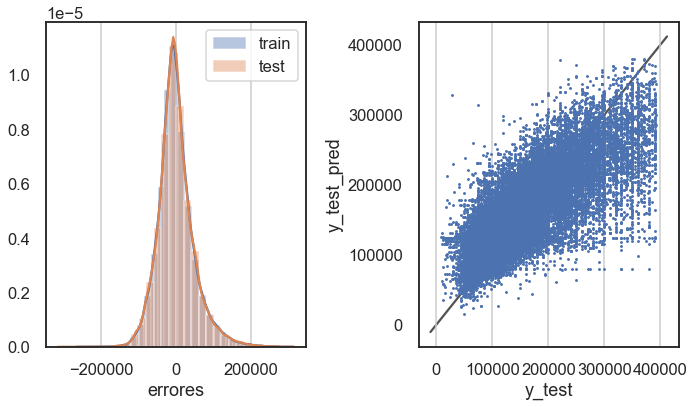

In [103]:
# Defino el modelo 
reg_L2 = Lasso(alpha=2.0, precompute=True, max_iter = 10000)

# Entreno el modelo
reg_L2.fit(X_train_poly, y_train)

# Predigo y Evaluo el modelo
evaluo_regresion(reg_L2, X,y, X_train_poly, X_test_poly, y_train, y_test)

#### Optimización de Hiperparámteros del Modelo Lasso con RandomSearchCV

In [104]:
# Defino la grillo del RandomSearchCV
param_dist = {'alpha':[20,10,2,1,0.5]}
              
# Defino mi estrategia con RandomSearchCV
modelo_L2 = RandomizedSearchCV(reg_L2, param_dist ,n_iter=20, cv=5, n_jobs= -1) #scoring='r2'

# Entreno el modelo
modelo_L2.fit(X_train_poly,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Lasso(alpha=2.0, copy_X=True, fit_intercept=True,
                                   max_iter=10000, normalize=False,
                                   positive=False, precompute=True,
                                   random_state=None, selection='cyclic',
                                   tol=0.0001, warm_start=False),
                   iid='deprecated', n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': [20, 10, 2, 1, 0.5]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [105]:
print('Mejores Hiperparámetros: '+str(modelo_L2.best_params_))
print('Mejor Score:'+str(modelo_L2.best_score_)+'\n')

scores_lasso = pd.DataFrame(modelo_L2.cv_results_)
scores_lasso

Mejores Hiperparámetros: {'alpha': 20}
Mejor Score:0.5976865285828132



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.546958,0.096725,0.022399,0.005425,20,{'alpha': 20},0.595880,0.597119,0.602888,0.595804,0.596742,0.597687,0.002649,1
1,1.821316,0.029993,0.014400,0.003200,10,{'alpha': 10},0.595829,0.597100,0.602868,0.595822,0.596781,0.597680,0.002643,2
2,2.174860,0.352994,0.017601,0.003200,2,{'alpha': 2},0.595768,0.597064,0.602832,0.595821,0.596793,0.597656,0.002639,3
3,1.966094,0.047899,0.012000,0.000001,1,{'alpha': 1},0.595759,0.597058,0.602826,0.595820,0.596792,0.597651,0.002638,4
4,1.379549,0.227426,0.009600,0.001959,0.5,{'alpha': 0.5},0.595755,0.597055,0.602823,0.595819,0.596792,0.597649,0.002638,5


Error R2 en Train: 0.5993173458016892
Raíz del error cuadrático medio en Train: 48459.99888298625
Error R2 en Test: 0.6035428054791008
Raíz del error cuadrático medio en Test: 48358.23583937321


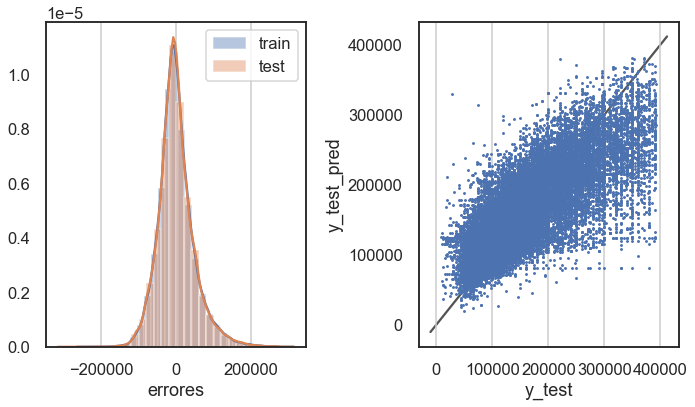

In [106]:
# Defino el modelo con los mejores Hiperpáremtros obtenidos con RandomSeachCV{alpha=20}
reg_L2n = Lasso(alpha= 20, precompute=True, max_iter= 10000, random_state=1)

# Entreno  el modelo 
reg_L2n.fit(X_train_poly,y_train)

# Predigo y evaluo el modelo
evaluo_regresion(reg_L2n, X,y, X_train_poly, X_test_poly, y_train, y_test)

In [107]:
print ('Pendientes: ', reg_L2n.coef_)
print ('Ordenada: ',reg_L2n.intercept_)

Pendientes:  [ 5.85391659e+03  7.33022204e+03  2.12198643e+04  2.73593603e+04
  7.86512229e+03 -2.02795408e+04 -1.00784027e+04  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.34348910e+03 -5.53197117e+03
 -2.09682844e+03  1.04139861e+03  3.21970702e+03  3.75662152e+03
  7.64634941e+02  8.26462444e+02  6.08434221e+02 -2.02923889e+02
 -5.21313178e+02 -1.04763165e+03  0.00000000e+00  1.55467989e+03
 -5.60202471e+02  2.16452722e+02 -1.37923758e+03 -1.50332279e+03
  1.52104865e+03 -1.35388522e+02  0.00000000e+00 -1.04531379e+02
 -3.51627398e+02 -9.40463551e+02  5.11792811e+02  0.00000000e+00
  1.10578602e+03  4.84206716e+02  5.56345926e+02 -2.11105106e+03
 -3.18871181e+03 -2.67070353e+03 -9.09080766e+02  0.00000000e+00
  1.11494416e+03  5.36799836e+02 -1.69511384e+03 -1.11582049e+03
 -1.06742218e+03  1.74816173e+03 -0.00000000e+00  4.49582051e+01
  1.57214136

### Modelos Ensamblados RandomForest

Dentro de los modelos ensamblados, los cuales ayudan a mejorar el rendimiento de los modelos mediante la combinación o ensamble de varios modelos para resolver un problema en particular en este caso predecir el precio de las viviendas. Elijo el modelo de `RandomForest` que utiliza el método de `agregación Bootstrap o Bagging` el cual extrae varias muestras, bootstrapped, de manera aleatoria y se entrenan los modelos de manera separada. Esas muestras se extraen del conjunto de entrenamiento y los submodelos se prueba utilizando el conjunto de prueba por lo tanto la predicción de salida final se combina en las proyecciones de todos los submodelos. 

In [108]:
# Defino mis datos de entrenamiento 'X' y la variable que quiero predecir 'y'
X = data7
y = data6['price']
X.shape

(111562, 18)

In [109]:
# Dividimos los datos en Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=30)

Error R2 en Train: 0.8461822913341033
Raíz del error cuadrático medio en Train: 30025.22687128766
Error R2 en Test: 0.7397745250247768
Raíz del error cuadrático medio en Test: 39178.44566947799


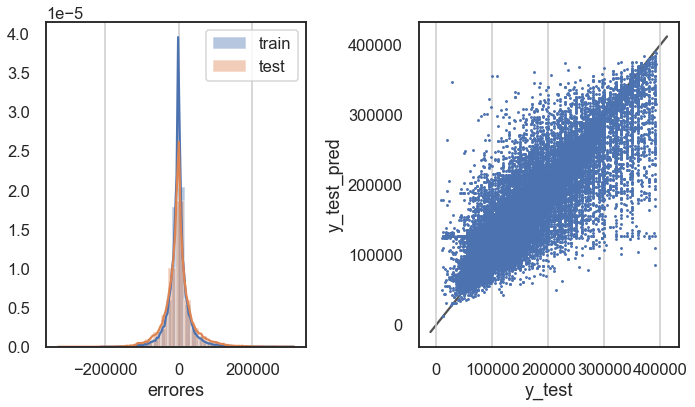

In [110]:
# Defino el modelo 
forest = RandomForestRegressor(n_jobs=-1, oob_score= True, random_state = 42)

# Entreno el modelo
forest.fit(X_train,y_train)

# Predigo y Evaluo el modelo
evaluo_regresion(forest, X,y, X_train, X_test, y_train, y_test)

In [111]:
forest.oob_score_

0.736907510537973

In [112]:
forest.feature_importances_

array([0.0336003 , 0.03046609, 0.33850827, 0.19547225, 0.18780044,
       0.03357931, 0.08992471, 0.00419883, 0.01424817, 0.00347777,
       0.00137959, 0.00128714, 0.01411373, 0.02399445, 0.01012081,
       0.0117665 , 0.00316653, 0.00289511])

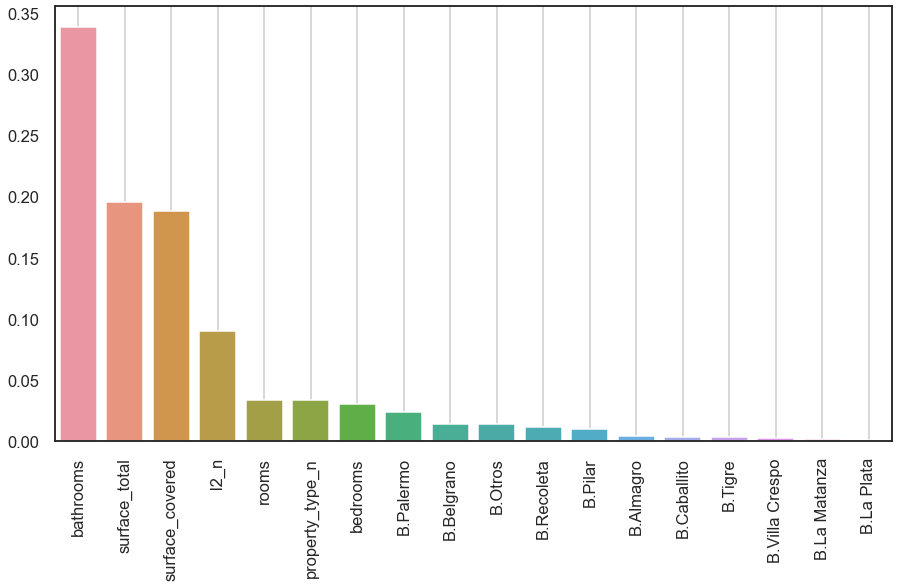

In [113]:
importances = forest.feature_importances_
columns = X_train.columns
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(figsize=(15,8))
ax = sns.barplot(columns[indices], importances[indices], order=columns[indices])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.grid(axis='x')
plt.show();

#### Optimización de Hiperparámteros del Modelo RandomForest con RandomSearchCV

In [114]:
# Defino la grillo del RandomSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.arange(start = 100, stop = 200, step= 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(start = 10, stop = 80, step= 4)]
max_depth.append(None)
bootstrap = [True, False]

# Creo la grilla Random
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

# Defino mi estrategia con RandomSearchCV
modelo_forest = RandomizedSearchCV(forest,param_grid, cv = 5, n_jobs = -1)  
# Entreno el modelo
modelo_forest.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [115]:
print('Mejores Hiperparámetros: '+str(modelo_forest.best_params_))
print('Mejor Score:'+str(modelo_forest.best_score_)+'\n')

scores_forest = pd.DataFrame(modelo_forest.cv_results_)
scores_forest

Mejores Hiperparámetros: {'n_estimators': 180, 'max_features': 'sqrt', 'max_depth': 74, 'bootstrap': True}
Mejor Score:0.7328093977888971



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.047196,0.003920,0.000000,0.000000,120,auto,14,False,"{'n_estimators': 120, 'max_features': 'auto', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
1,0.042051,0.001792,0.000000,0.000000,140,sqrt,62,False,"{'n_estimators': 140, 'max_features': 'sqrt', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
2,0.039994,0.002529,0.000000,0.000000,160,auto,34,False,"{'n_estimators': 160, 'max_features': 'auto', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
3,16.244278,0.546052,0.282355,0.041838,160,sqrt,10,True,"{'n_estimators': 160, 'max_features': 'sqrt', ...",0.658406,0.654683,0.658727,0.653758,0.655828,0.656281,0.001981,4
4,0.048793,0.011142,0.000000,0.000000,120,sqrt,34,False,"{'n_estimators': 120, 'max_features': 'sqrt', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
5,16.813387,0.674013,1.320998,0.479778,100,sqrt,74,True,"{'n_estimators': 100, 'max_features': 'sqrt', ...",0.735587,0.725894,0.734831,0.729025,0.736453,0.732358,0.004152,2
6,0.067189,0.014617,0.000000,0.000000,120,sqrt,78,False,"{'n_estimators': 120, 'max_features': 'sqrt', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
7,0.051190,0.017043,0.000000,0.000000,160,sqrt,78,False,"{'n_estimators': 160, 'max_features': 'sqrt', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
8,56.861173,3.721262,2.168659,0.230438,160,auto,70,True,"{'n_estimators': 160, 'max_features': 'auto', ...",0.730583,0.722907,0.728419,0.726046,0.733144,0.728220,0.003545,3
9,25.544102,6.946405,1.506168,0.837908,180,sqrt,74,True,"{'n_estimators': 180, 'max_features': 'sqrt', ...",0.736135,0.726346,0.734632,0.730128,0.736806,0.732809,0.003983,1


Error R2 en Train: 0.8471024840427591
Raíz del error cuadrático medio en Train: 29935.281309145736
Error R2 en Test: 0.7440300876597077
Raíz del error cuadrático medio en Test: 38856.77540479894


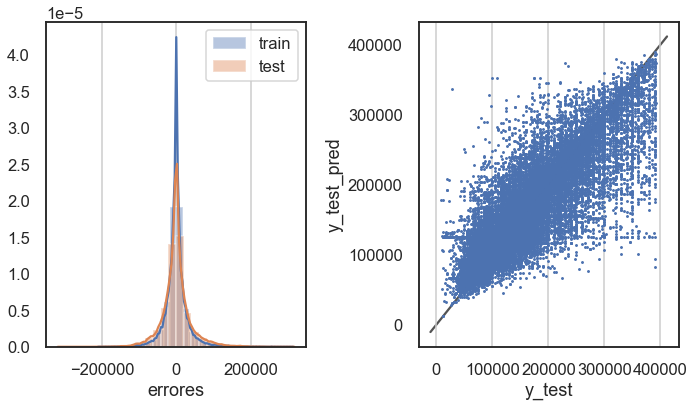

In [116]:
# Defino el modelo con los mejores Hiperpáremtros obtenidos con RandomSeachCV
forestn = RandomForestRegressor(n_estimators=180, max_features='sqrt',max_depth=38,bootstrap=True,n_jobs=-1)

# Entreno el modelo
forestn.fit(X_train,y_train)

# Predigo y Evaluo el modelo
evaluo_regresion(forestn, X,y, X_train, X_test, y_train, y_test)

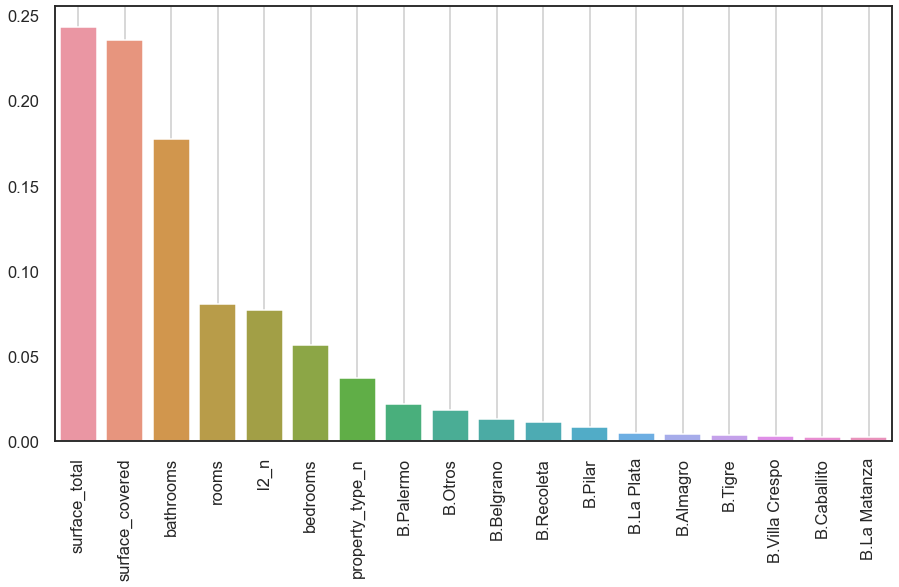

In [117]:
importances = forestn.feature_importances_
columns = X_train.columns
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(figsize=(15,8))
ax = sns.barplot(columns[indices], importances[indices], order=columns[indices])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.grid(axis='x')
plt.show();

### Comparación de Modelos

Comparando los modelos del punto B entre sí considero que los modelos de regularización de `Ridge y Lasso` no tuvieron un rendimiento óptimo como esperaba. De acuerdo a la teoría Ridge es útil cuando sospechemos que la mayoría de los atributos de entrada (features) están  correlacionados  entre sí, que no sería este caso. Mientras que Lasso es útil cuando se sabe que varios de los features son irrelevantes o no están tan correlacionados entre sí como sucede en este caso.
El mejor rendimiento lo obtuve con el modelo de `RandomForest` e inclusive mejoró sustancialmente el desempeño obtenido con el modelo de `Tree` del punto A esto se debe a que utilicé un numero mayor de features para predecir el modelo a parte de la robustez que tiene el ReandomForest. Es importante aclarar que el modelo de RandomForest insumió un mayor costo computacional pero considero que vale la pena por los resultados obtenidos.

## PARTE C - Interpretación de modelos

De acuerdo a lo que el modelo permite, responde algunas o todas las siguientes preguntas:

1. ¿Qué variables fueron relevantes para el modelo para hacer una predicción? ¿Cuáles no? 
Mediante el gráfico **HEATMAT** puede visualizar las correlaciones exsistentes entre las diferente features y eso lo complemente con el listado de las correlaciones positivas y negativas de las mismas. Con el modelo de RANDOMFOREST, mediante el atributo de **feature_importances** puede observar la importancia de cada features para predicir el precio. En resumen, todo lo antes mencionado me permite inferir que las features `surface_total,surface_covered, bathrooms, rooms, l2_n (zonas),bethrooms, property_type_n, B.Palermo` son las features más relevantes para predecir mi modelo.  Comparando el feature_impotances del modelo de **RandomForest** contra el **RandomForest optimizado** es notable como cambian los feature mas importante. Mientras par el primero **bathrooms** es la más importante para el optimizado es **surface_total** quedando **bathrooms** en la tercer posición. Eso demuestra como un con mayor numero de arboles se empiezan a mejorar cada uno de las participaciones de las features. A continuación muestra las feature_importances de un grupo de arboles resultantes del RandomForest optimizado donde vemos como van variando las importancias de un arbol a otro.


In [118]:
lista_arboles=[10,40,60,80,100,120]

for i in lista_arboles:
    print(f'Features mas importantes arbol: {i}')
    feature_importantes=pd.Series(forestn[i].feature_importances_,index=X_train.columns)
    print(feature_importantes)

Features mas importantes arbol: 10
rooms              0.022130
bedrooms           0.085802
bathrooms          0.335300
surface_total      0.166565
surface_covered    0.192883
property_type_n    0.030870
l2_n               0.076636
B.Almagro          0.005769
B.Belgrano         0.012744
B.Caballito        0.001744
B.La Matanza       0.002252
B.La Plata         0.002486
B.Otros            0.022775
B.Palermo          0.016444
B.Pilar            0.009198
B.Recoleta         0.007931
B.Tigre            0.004160
B.Villa Crespo     0.004313
dtype: float64
Features mas importantes arbol: 40
rooms              0.033077
bedrooms           0.066735
bathrooms          0.058253
surface_total      0.410618
surface_covered    0.178799
property_type_n    0.053590
l2_n               0.111325
B.Almagro          0.004149
B.Belgrano         0.010094
B.Caballito        0.002984
B.La Matanza       0.001810
B.La Plata         0.002190
B.Otros            0.019054
B.Palermo          0.024649
B.Pilar            

2. De los dos modelos de regularización `Laso y Ridge` utilizados, como antes había mencionado,  para este caso es recomendable el modelo de `Lasso` ya que al estar poco correlacionados los features lo que hace este modelo es llevar a 0 aquellos features que no son relevantes esto se puede observar en el listado de las 189 pendientes que arroja el modelo donde se visualiza un gran número de ellas iguales a cero. De esta manera `Lasso` reduce el número de features necesarias para predecir el modelo pero en este caso el rendimiento del mismo no fue tan bueno como el que obtuve con el modelo de `RandomForest`.

Error R2 en Train: 0.8471024840427591
Raíz del error cuadrático medio en Train: 29935.281309145736
Error R2 en Test: 0.7440300876597077
Raíz del error cuadrático medio en Test: 38856.77540479894


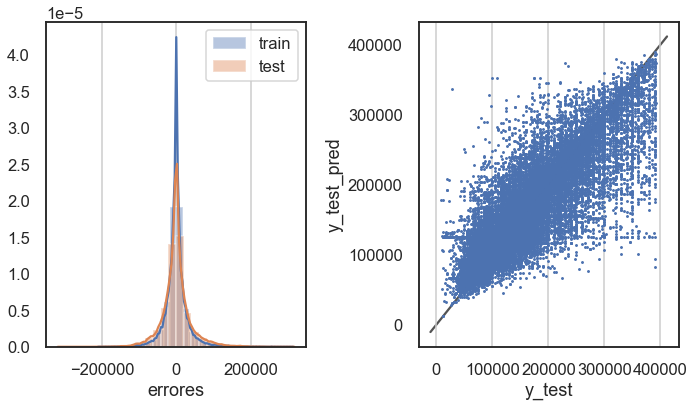

In [119]:
evaluo_regresion(forestn, X,y, X_train, X_test, y_train, y_test)

3. En la distribución (Histogramas) de los errores se puede observar que tanto en test como en train los errores están más concentrados alrededor de la media. En el grafico de y_test vs y_test_pred se puede observar que la mayoría de los puntos se acercan o se agrupan cerca de la diagonal pero a partir de y_test =300000 empieza a predicir mal ya que se puede observar que los puntos están más lejos de la recta hacia abajo es decir que la predicción no es muy buena.

4. Como mejora de la metodología aplicada cabe mencionar:
    1. Considero que haber sacado del dataset original las columnas latitud y longitud no fue óptimo ya que seguramente con esos features más los barrios se podría obtener mapas de calor con las zonas mejores cotizadas (precios más altos y propiedades más demandadas según la ubicación).
    2. Otro punto a mencionar es la decisión de aplicar el OneHotEncoder sobre los barrios ya que según la teoría el LabelEncoder realiza una jerarquización y por eso motivo lo descarte, pero el resultado final fue trabajar con un dataset con muchas features de las cuales justamente los barrios no me aportaron mucho en la predicción de mi  modelo. Para verificar esto aplicaré un label encoder sobre los barrios y realizaré nuevamente el análisis con ese nuevo dataset para ver los resultados.
    

In [120]:
# Elijo el data5 que es sobre el cual aplico el OneHotEncoder en la línea de código 30
data6 = data5.copy()
data6

,l2,l3,rooms,bedrooms,property_type,price,bathrooms,surface_total,surface_covered,property_type_n,l2_n
0,Capital Federal,Otros,7.0,7.0,Departamento,153000.0,2.0,140.0,140.0,0,0
1,Capital Federal,Otros,2.0,1.0,PH,159000.0,2.0,70.0,58.0,1,0
2,Capital Federal,Palermo,2.0,1.0,PH,125000.0,1.0,45.0,45.0,1,0
3,Capital Federal,Palermo,2.0,1.0,PH,295000.0,1.0,85.0,50.0,1,0
4,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,PH,40000.0,1.0,50.0,35.0,1,2
...,...,...,...,...,...,...,...,...,...,...,...
146655,Bs.As. G.B.A. Zona Sur,Otros,2.0,1.0,Departamento,165000.0,1.0,54.0,48.0,0,2
146656,Bs.As. G.B.A. Zona Norte,Pilar,4.0,3.0,Departamento,130000.0,2.0,164.0,90.0,0,1
146657,Bs.As. G.B.A. Zona Norte,Pilar,1.0,1.0,Departamento,73000.0,1.0,50.0,35.0,0,1
146658,Bs.As. G.B.A. Zona Norte,Pilar,2.0,1.0,Departamento,68000.0,1.0,38.0,38.0,0,1


In [121]:
label_enco = LabelEncoder()
l3_label = label_enco.fit_transform(data6.l3)
data6=data6.assign(lab_barrios=l3_label)

In [122]:
data6.head()

,l2,l3,rooms,bedrooms,property_type,price,bathrooms,surface_total,surface_covered,property_type_n,l2_n,lab_barrios
0,Capital Federal,Otros,7.0,7.0,Departamento,153000.0,2.0,140.0,140.0,0,0,5
1,Capital Federal,Otros,2.0,1.0,PH,159000.0,2.0,70.0,58.0,1,0,5
2,Capital Federal,Palermo,2.0,1.0,PH,125000.0,1.0,45.0,45.0,1,0,6
3,Capital Federal,Palermo,2.0,1.0,PH,295000.0,1.0,85.0,50.0,1,0,6
4,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,PH,40000.0,1.0,50.0,35.0,1,2,4


In [123]:
# Elimino los outliers
rooms_outliers = elimino_outliers(data6,'rooms')
data6 = data6[~rooms_outliers]
bedrooms_outliers = elimino_outliers(data6,'bedrooms')
data6 = data6[~bedrooms_outliers]
bathrooms_outliers = elimino_outliers(data6,'bathrooms')
data6 = data6[~bedrooms_outliers]
sup_tot_outliers = elimino_outliers(data6,'surface_total')
data6 = data6[~sup_tot_outliers]
price_outliers = elimino_outliers(data6,'price')
data6 = data6[~price_outliers]

In [124]:
# Mi dataset final sin outliers
data6.shape

(120471, 12)

In [125]:
# Elimino del dataset las columnas no numericas 
data6 = data6.drop(['l3','l2','property_type'],axis = 'columns')
data6.head()

,rooms,bedrooms,price,bathrooms,surface_total,surface_covered,property_type_n,l2_n,lab_barrios
1,2.0,1.0,159000.0,2.0,70.0,58.0,1,0,5
2,2.0,1.0,125000.0,1.0,45.0,45.0,1,0,6
3,2.0,1.0,295000.0,1.0,85.0,50.0,1,0,6
4,2.0,1.0,40000.0,1.0,50.0,35.0,1,2,4
5,2.0,1.0,150000.0,1.0,56.0,56.0,1,0,10


In [126]:
# Último paso escalodo de datos sin la variable objetivo
sta_scale = StandardScaler()
data7 = pd.DataFrame(sta_scale.fit_transform(data6.drop(['price'],axis=1)))

In [127]:
data7.head()

,0,1,2,3,4,5,6,7
0,-0.700308,-0.780064,0.974287,-0.217622,-0.038204,1.023437,-0.616762,-0.010479
1,-0.700308,-0.780064,-0.589440,-0.892282,-0.077700,1.023437,-0.616762,0.413856
2,-0.700308,-0.780064,-0.589440,0.187174,-0.062509,1.023437,-0.616762,0.413856
3,-0.700308,-0.780064,-0.589440,-0.757350,-0.108080,1.023437,1.466713,-0.434813
4,-0.700308,-0.780064,-0.589440,-0.595432,-0.044281,1.023437,-0.616762,2.111193


In [128]:
data7.rename(columns={0:'rooms',1:'bedrooms',2:'bathrooms',3:'surface_total',4:'surface_covered',
                       5:'property_type_n',6:'l2_n',7:'lab_barrios'}, inplace=True)
data7.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type_n,l2_n,lab_barrios
0,-0.700308,-0.780064,0.974287,-0.217622,-0.038204,1.023437,-0.616762,-0.010479
1,-0.700308,-0.780064,-0.589440,-0.892282,-0.077700,1.023437,-0.616762,0.413856
2,-0.700308,-0.780064,-0.589440,0.187174,-0.062509,1.023437,-0.616762,0.413856
3,-0.700308,-0.780064,-0.589440,-0.757350,-0.108080,1.023437,1.466713,-0.434813
4,-0.700308,-0.780064,-0.589440,-0.595432,-0.044281,1.023437,-0.616762,2.111193


In [129]:
# Visualizo las columnas positivamente correlacionadas en orden creciente de correlación
corr    = data6.corr()
pos_cor = corr['price'] >0
neg_cor = corr['price']  <0
corr['price'][pos_cor].sort_values(ascending = False)

price              1.000000
bathrooms          0.577740
rooms              0.530812
surface_total      0.524008
bedrooms           0.497907
surface_covered    0.046399
lab_barrios        0.028326
property_type_n    0.025653
Name: price, dtype: float64

In [130]:
# Correlaciones negativas
corr['price'][neg_cor].sort_values(ascending = False)

l2_n   -0.218126
Name: price, dtype: float64

In [131]:
# Defino mis datos de entrenamiento 'X' y la variable que quiero predecir 'y'
X = data7
y = data6['price']
X.shape

(120471, 8)

In [132]:
# Dividimos los datos en Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=30)

* Solamente aplicaré el modelo de **RandomForest** para comparar el rendimiento no solo a nivel de la predicción sino tambien computacional.

Error R2 en Train: 0.8734966229981144
Raíz del error cuadrático medio en Train: 31190.049091201374
Error R2 en Test: 0.7655358026324317
Raíz del error cuadrático medio en Test: 42386.75107469057


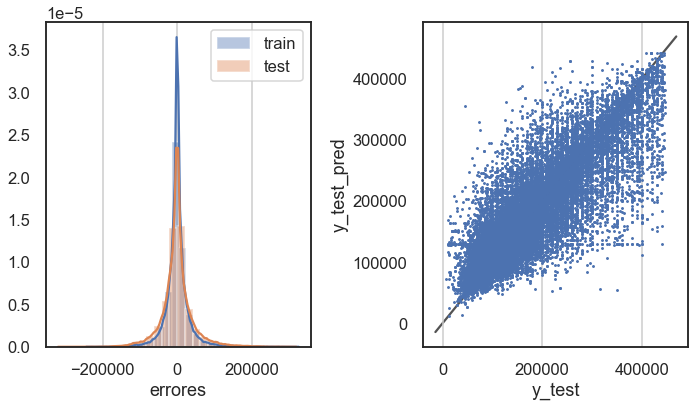

In [133]:
# Defino el modelo 
forest = RandomForestRegressor(n_jobs=-1, oob_score= True, random_state = 42)

# Entreno el modelo
forest.fit(X_train,y_train)

# Predigo y Evaluo el modelo
evaluo_regresion(forest, X,y, X_train, X_test, y_train, y_test)

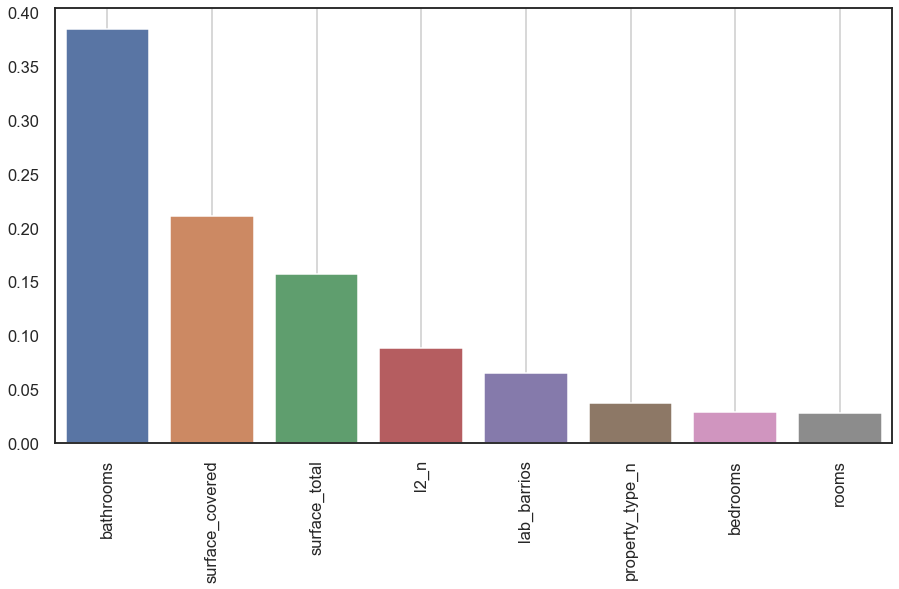

In [134]:
importances = forest.feature_importances_
columns = X_train.columns
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(figsize=(15,8))
ax = sns.barplot(columns[indices], importances[indices], order=columns[indices])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.grid(axis='x')
plt.show();

#### Optimización de Hiperparámteros del Modelo RandomForest con RandomSearchCV con la misma grilla

In [135]:
# Defino la grillo del RandomSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.arange(start = 100, stop = 200, step= 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(start = 10, stop = 80, step= 4)]
max_depth.append(None)
bootstrap = [True, False]

# Creo la grilla Random
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

# Defino mi estrategia con RandomSearchCV
modelo_forest = RandomizedSearchCV(forest,param_grid, cv = 5, n_jobs = -1)  
# Entreno el modelo
modelo_forest.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [136]:
print('Mejores Hiperparámetros: '+str(modelo_forest.best_params_))
print('Mejor Score:'+str(modelo_forest.best_score_)+'\n')

Mejores Hiperparámetros: {'n_estimators': 180, 'max_features': 'sqrt', 'max_depth': 42, 'bootstrap': True}
Mejor Score:0.7624204327309158



Error R2 en Train: 0.8740991484359171
Raíz del error cuadrático medio en Train: 31115.682584051585
Error R2 en Test: 0.7702406471459143
Raíz del error cuadrático medio en Test: 41959.32193044344


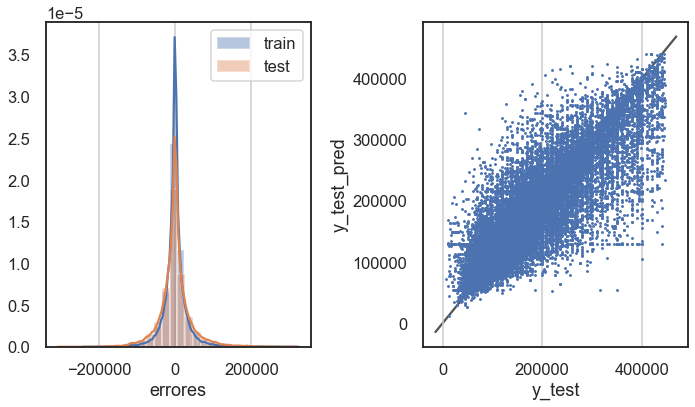

In [137]:
# Defino el modelo con los mejores Hiperpáremtros obtenidos con RandomSeachCV
forestn = RandomForestRegressor(n_estimators=100, max_features='sqrt',max_depth=30,bootstrap=True,n_jobs=-1)

# Entreno el modelo
forestn.fit(X_train,y_train)

# Predigo y Evaluo el modelo
evaluo_regresion(forestn, X,y, X_train, X_test, y_train, y_test)

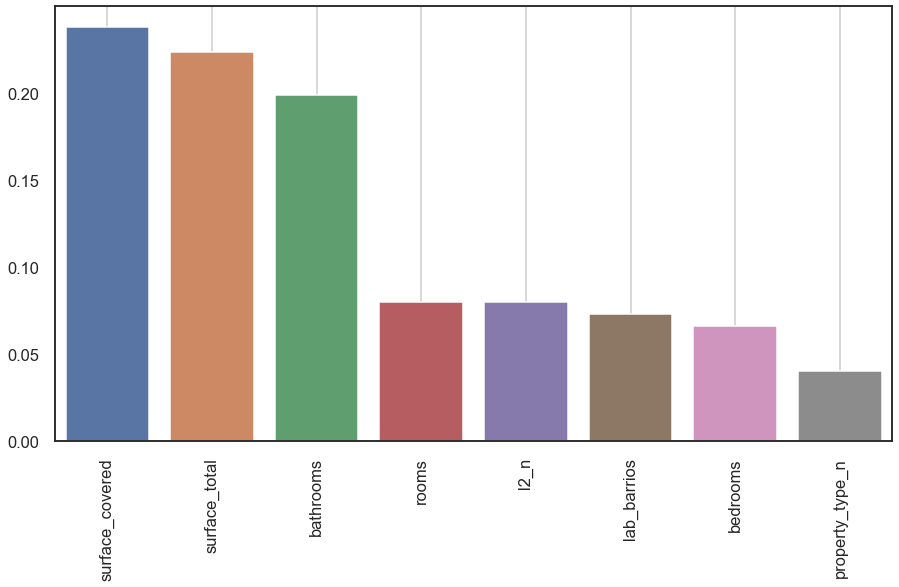

In [138]:
# Importancia de los features con el modelo optimizado
importances = forestn.feature_importances_
columns = X_train.columns
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(figsize=(15,8))
ax = sns.barplot(columns[indices], importances[indices], order=columns[indices])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.grid(axis='x')
plt.show();

Como conclusión final queda demostrado que no era necesario aplicar el OneHotEncoder inclusive obtuve mejores resultados con respecto al rendimiento del R2 y Raíz del error cuadrático medio tanto en test y train.